**NER**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import date, timedelta

import xgboost as xgb
from xgboost import plot_importance, plot_tree
import sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")

In [2]:
# raot_cta_ner = pd.read_csv('ner_data.csv')
raot_cta_ner = pd.read_csv('cta_ner_standard_deviation_msa.csv')
print(raot_cta_ner['PROPERTY_ID'].nunique())
raot_cta_ner.head()
print(raot_cta_ner.shape)

11920
(1221651, 14)


In [3]:
raot_cta_ner['WEEK_START'] = pd.to_datetime(raot_cta_ner['SURVEY_DATE']).dt.date
raot_cta_ner = raot_cta_ner.sort_values(by='WEEK_START')

# select rows where date is between given start/end date (inclusive)
start_date = pd.to_datetime('1/1/2015')
end_date = pd.to_datetime('8/14/2022')

raot_cta_ner = raot_cta_ner.loc[
    (raot_cta_ner['WEEK_START'] >= start_date) & (raot_cta_ner['WEEK_START'] <= end_date)]

In [4]:
def start_week_date(survey_date):
    start_date = survey_date - timedelta(days=survey_date.weekday())
    
    return start_date

raot_cta_ner['WEEK_START'] = raot_cta_ner.apply(lambda x: start_week_date(x['WEEK_START']), axis=1)
raot_cta_ner.tail()

,WEEK_START,PROPERTY_ID,SURVEY_ID,SURVEY_DATE,STATE,STATE_ID,MSA,MSA_ID,SUBMARKET,SUBMARKET_ID,NER,NER_T4,UNITS,UNITS_T4
518033,2022-08-08,602c20c37f74cc00030d7e8f,62f8494c3c85ac916425ffa8,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Diego, CA",dfad4dd3-9313-6c18-50c1-0de9821b0d67,Vista,6cb2d14c09e8175b2af2a79a678b4f28,3191.593103,3109.348275,290.0,290.0
617496,2022-08-08,5e0663eaa41f7e001df91767,62f96fb8c433445bd07dd436,2022-08-14,North Carolina,3d798905-622e-7dd4-30d1-fa49906c6af0,"Charlotte, NC",09fd9026-18a1-a133-6510-17e3600a1c39,Harris Blvd/Mallard Creek Church Rd,a86c5516abb6853118fe5369f024627c,1637.105960,1516.932119,302.0,302.0
338967,2022-08-08,5cd08f0dce7ddb001540bbc4,62f95400ed9052c27d09bb2c,2022-08-14,Arizona,60682b07-6de7-18cc-618b-dfd375ec2200,"Phoenix, AZ",3593fab5-48d8-741f-9eeb-16a13099553c,South Tempe/Ahwatukee,631f1286def472f50e413889a1f6a6d7,1883.733333,1880.816666,300.0,300.0
576180,2022-08-08,5b004a206407dc00135180dd,62f97f5332ebcf0dc3370c23,2022-08-14,California,3e5ffbdd-4051-7165-7db7-21bdd14930db,"San Jose, CA",6e9d1acc-9171-a389-2994-fd1657f71fbe,Sunnyvale,eee20c797b9800c9bf98ceb2ec928b3c,3108.550913,3108.550913,766.0,766.0
518070,2022-08-08,61d76a6f85a40a002a0c469f,62f94c94eac34a852ab61739,2022-08-14,Oregon,bb3403f2-1a88-5959-3ee9-b369eab25b9a,"Portland, OR",1ac6ab71-5209-9f74-4e4b-f5a746648edb,Beaverton,c1b4899c4973474fa9b17a89deec49bf,2066.516129,2066.516129,124.0,124.0


In [5]:
raot_cta_ner = raot_cta_ner[['WEEK_START', 'PROPERTY_ID', 'STATE', 'MSA', 'SUBMARKET', 'NER_T4']]

## XGBOOST

In [6]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['STATE']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER_T4')

In [7]:
print(list(subsets.keys())[0])
list(subsets.values())[0]

Alabama


,NER_T4
WEEK_START,
2017-10-09,935.752943
2017-10-16,937.945072
2017-10-23,938.366017
2017-10-30,945.524074
2017-11-06,949.513454
...,...
2022-07-11,1291.448237
2022-07-18,1293.993420
2022-07-25,1288.151418


In [28]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [29]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [13]:
def datetime_index(df, date_col):
    datetime_series = pd.to_datetime(df[date_col])
    datetime_index = pd.DatetimeIndex(datetime_series.values)
    df2 = df.set_index(datetime_index)
    df2.drop('date',axis=1,inplace=True)
    return df2

In [18]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    #df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth']]
    if label:
        y = df[label]
        return X, y
    return X

In [19]:
def evaluation(test_data, predictions):
    mape = mean_absolute_percentage_error(predictions, test_data)
    return mape

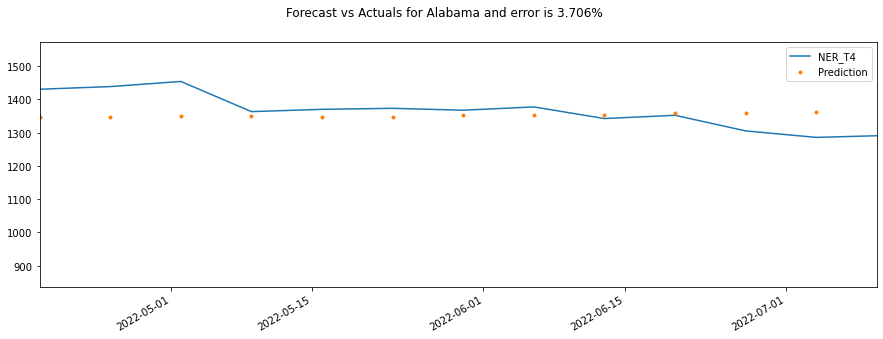

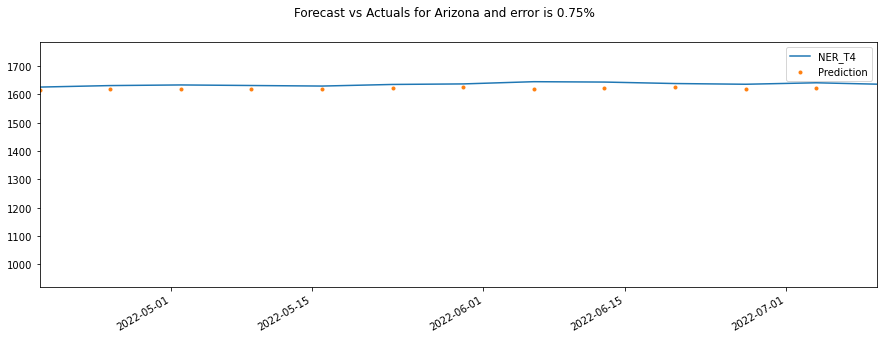

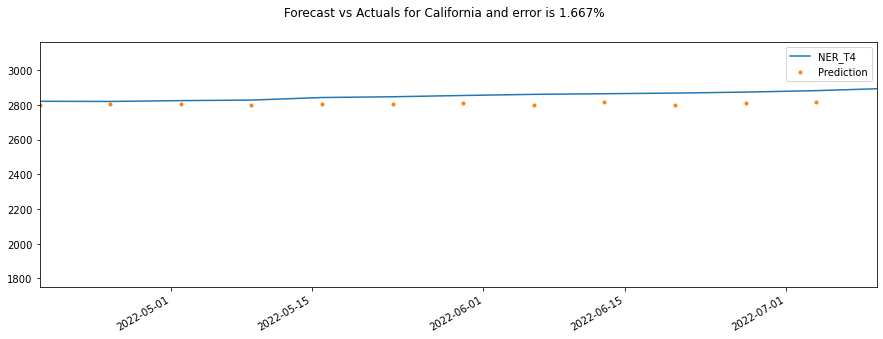

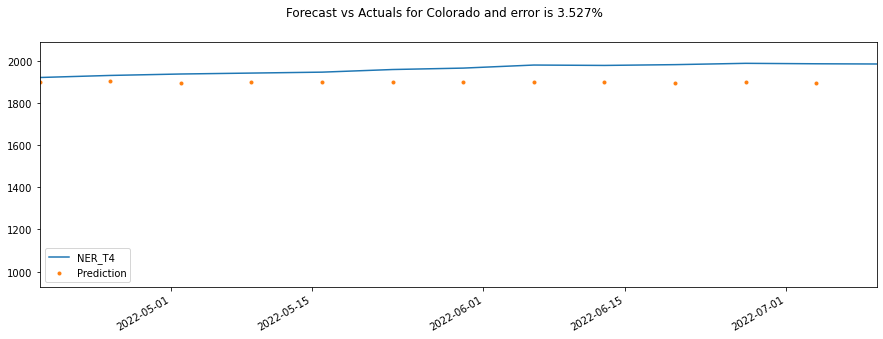

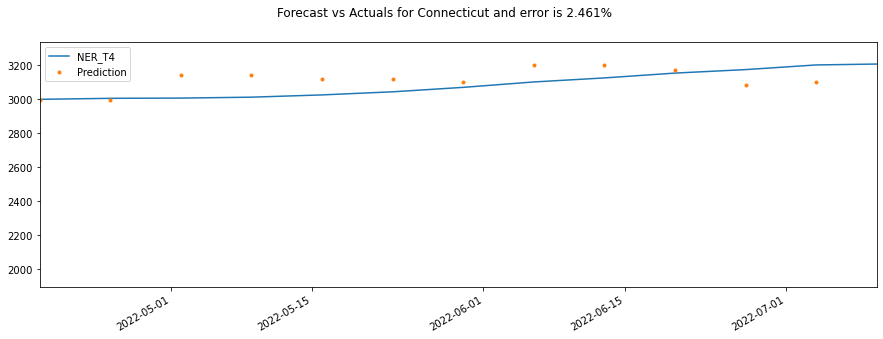

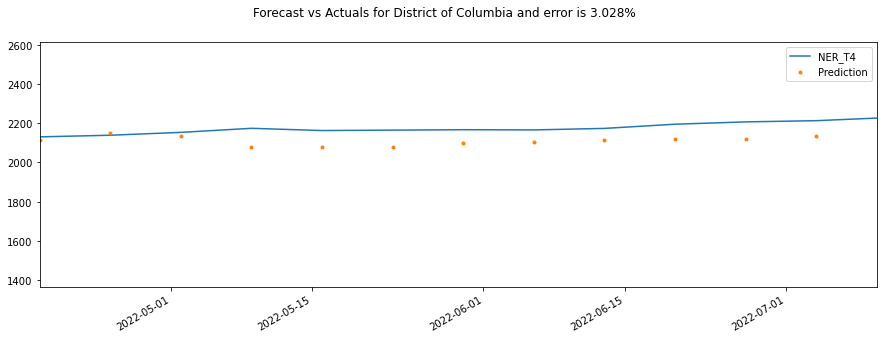

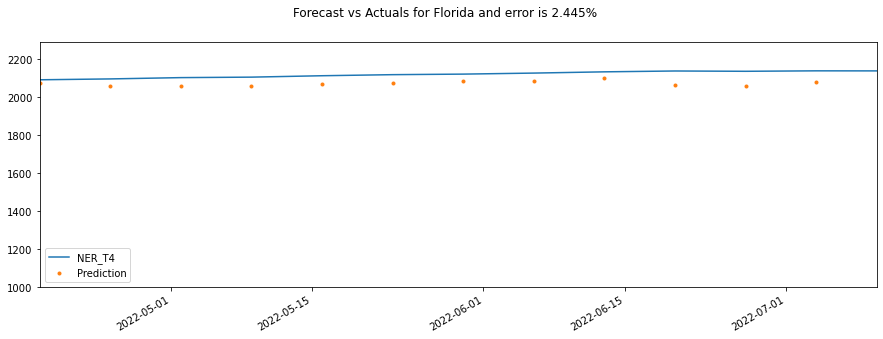

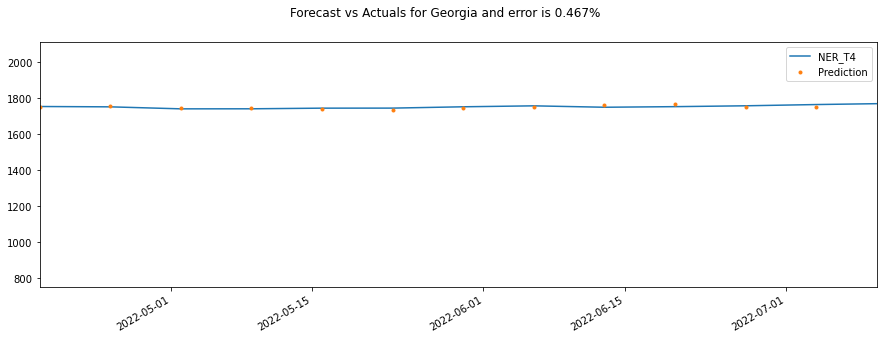

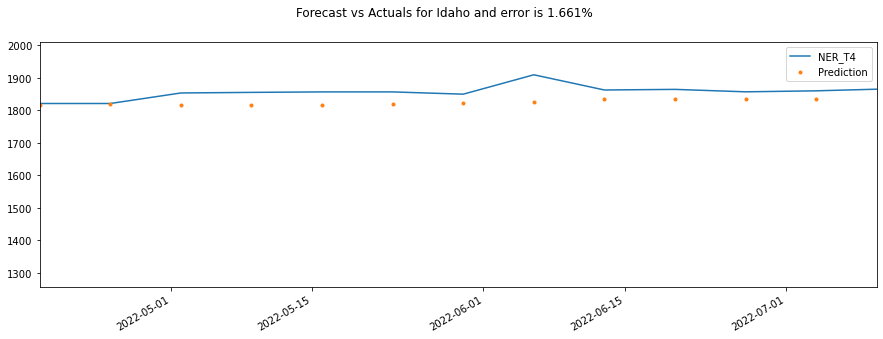

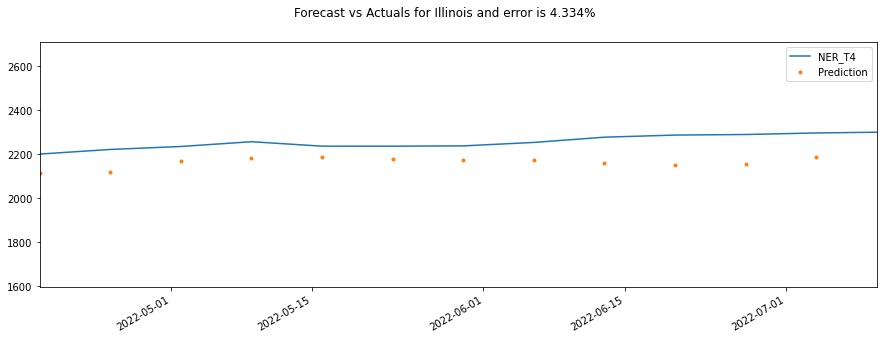

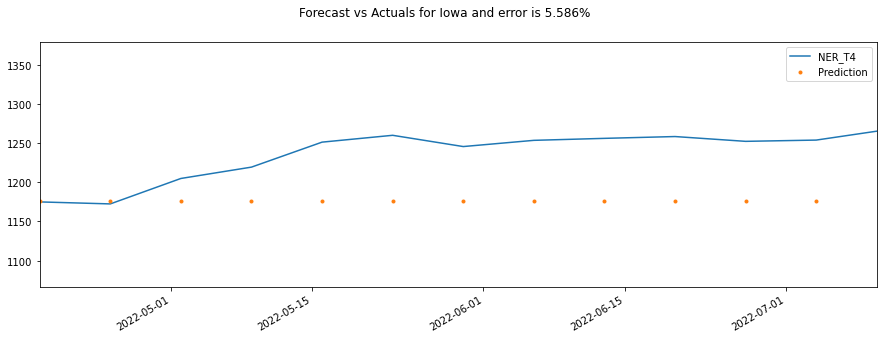

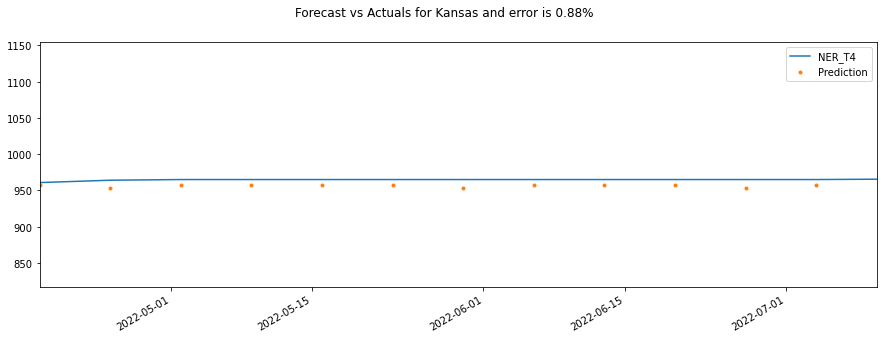

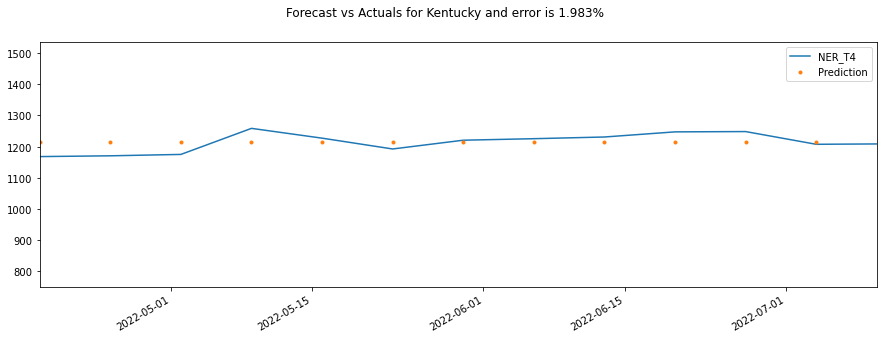

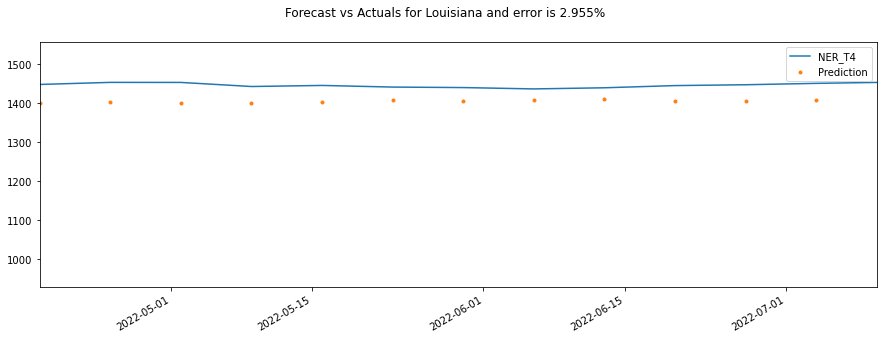

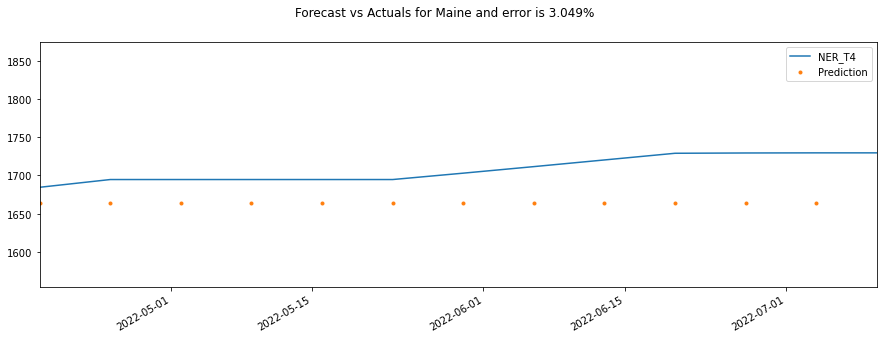

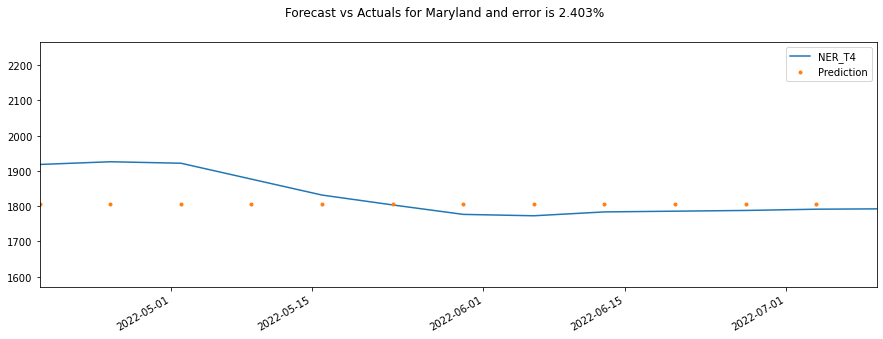

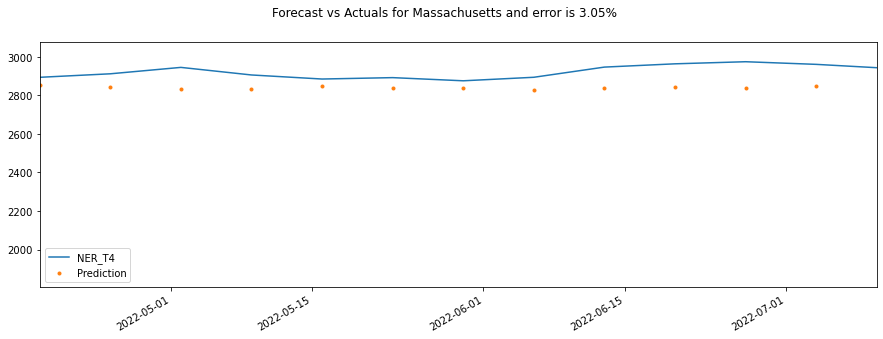

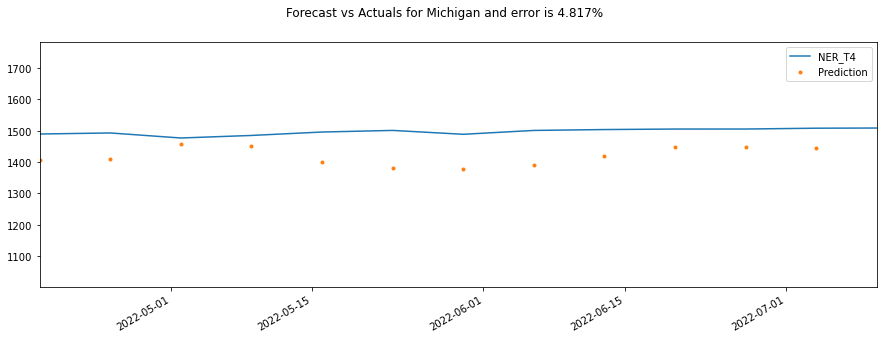

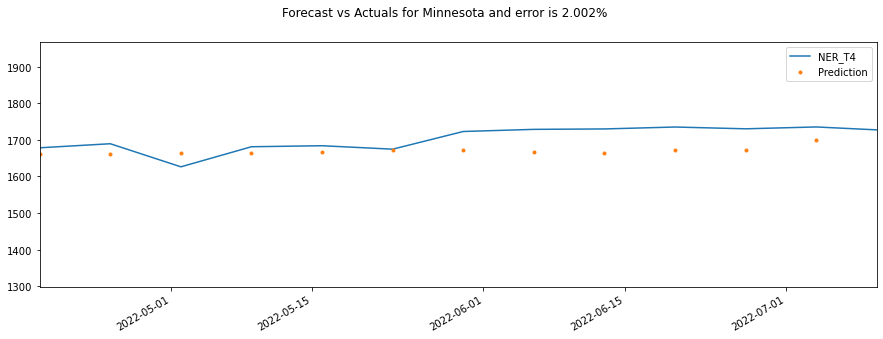

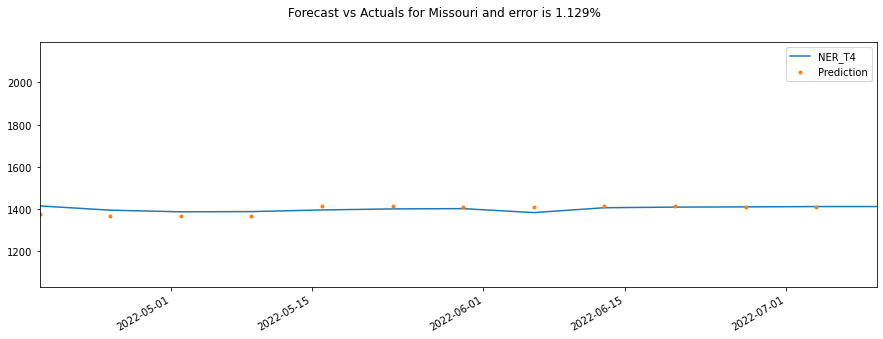

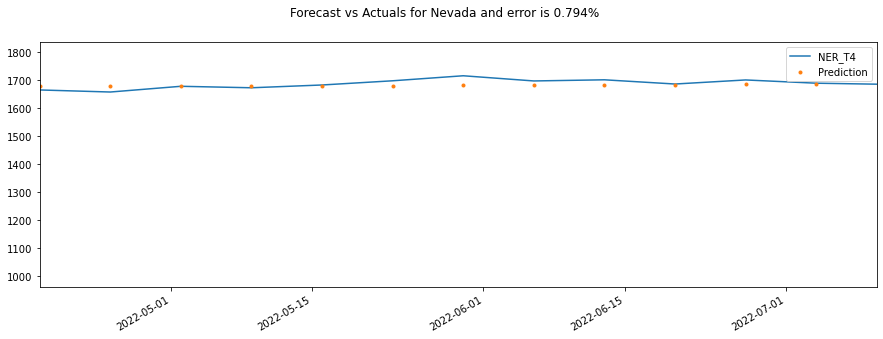

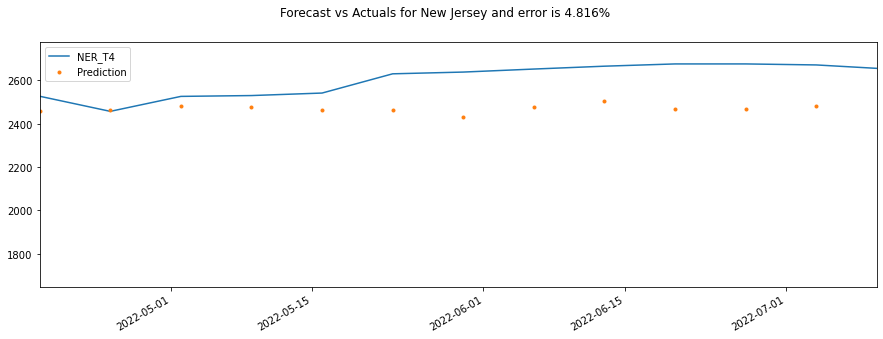

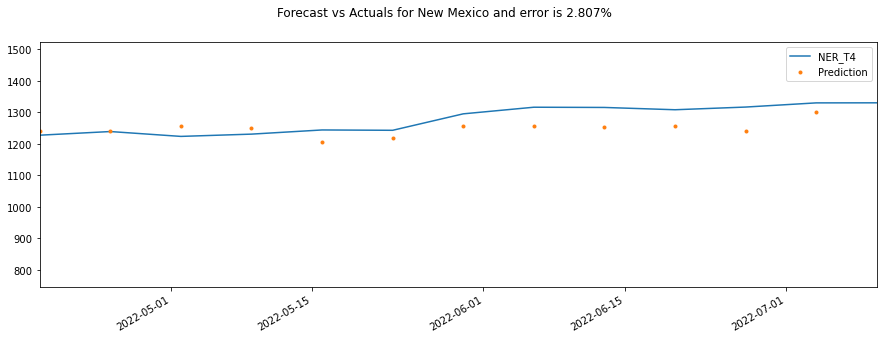

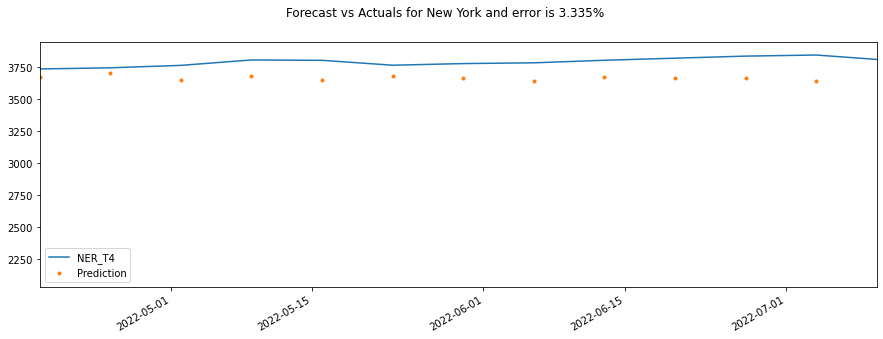

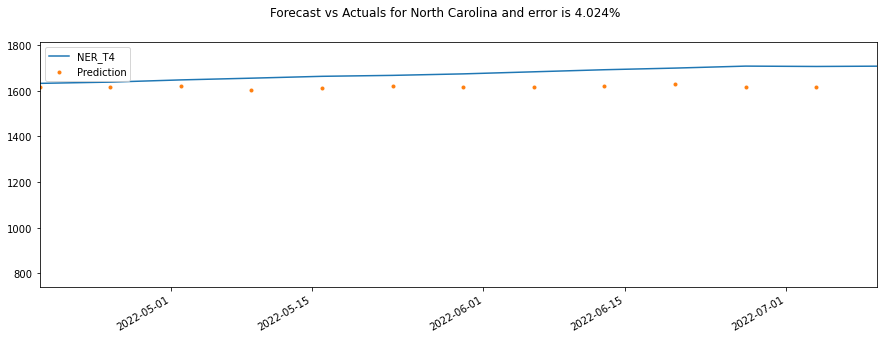

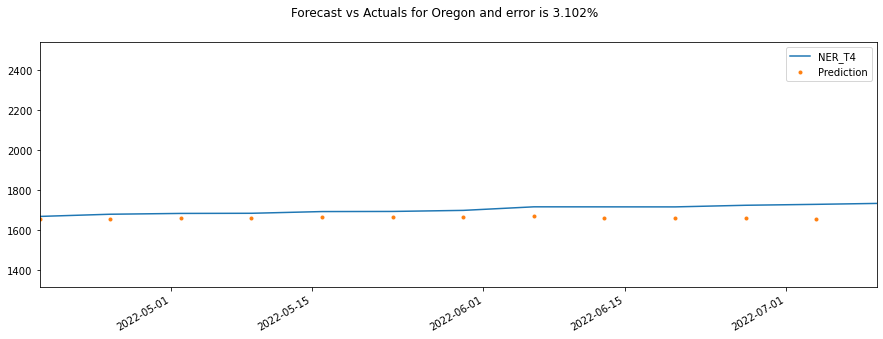

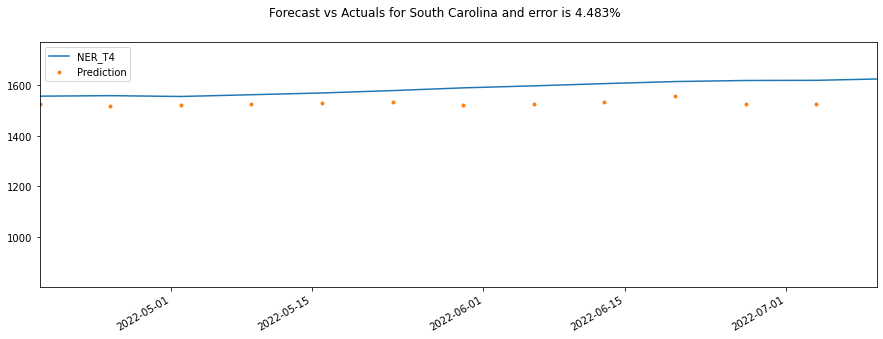

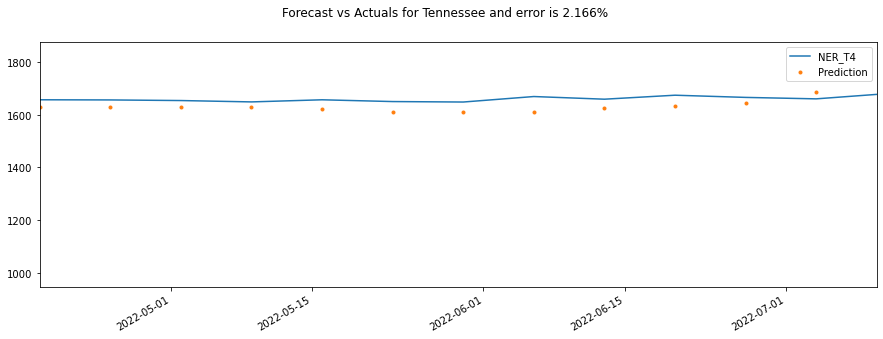

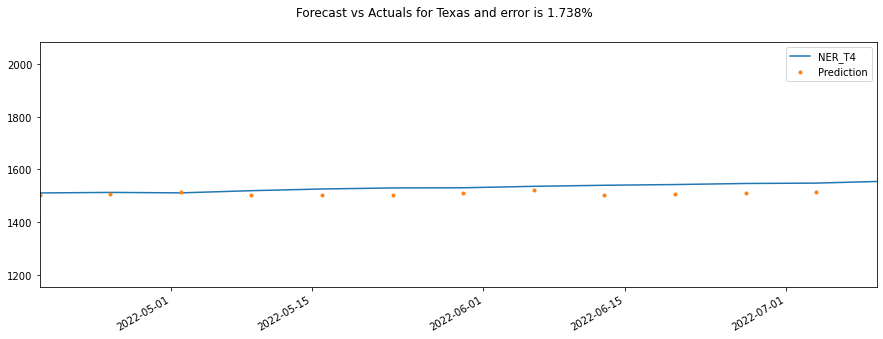

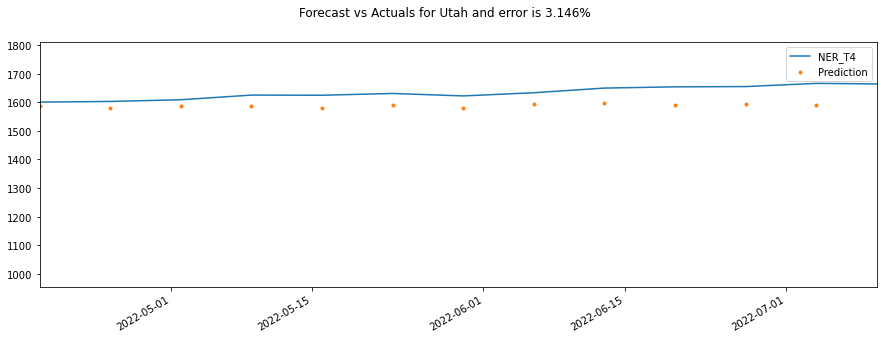

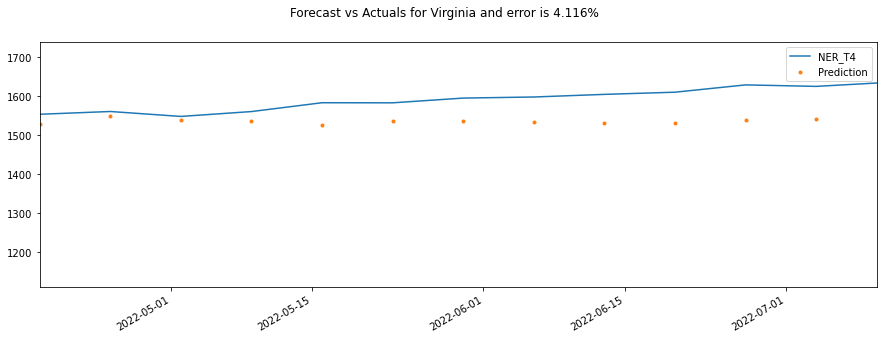

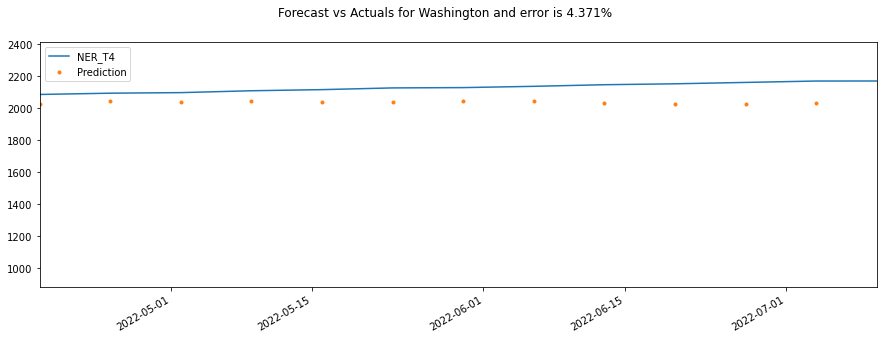

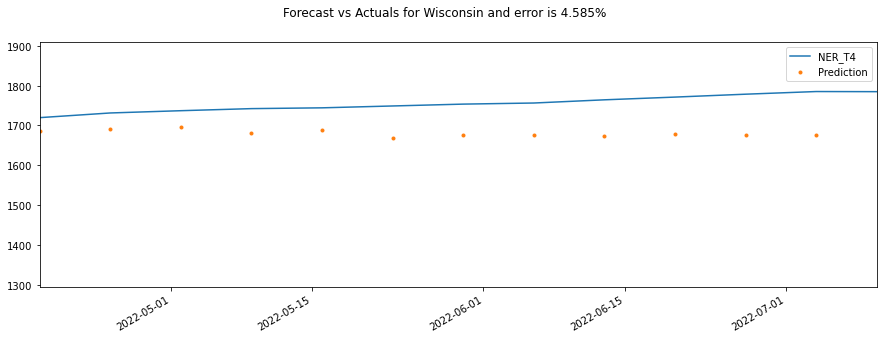

In [35]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 4, 4)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    X_test, y_test = create_features(df_test, label='NER_T4')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    mape = evaluation(df_test['NER_T4'], df_test['Prediction'])
    
    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='04-18-2022', upper='07-10-2022')
        ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

        mape = evaluation(df_test['NER_T4'], df_test['Prediction'])
        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1350: Empty dataset at worker: 0
[17:16:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:1

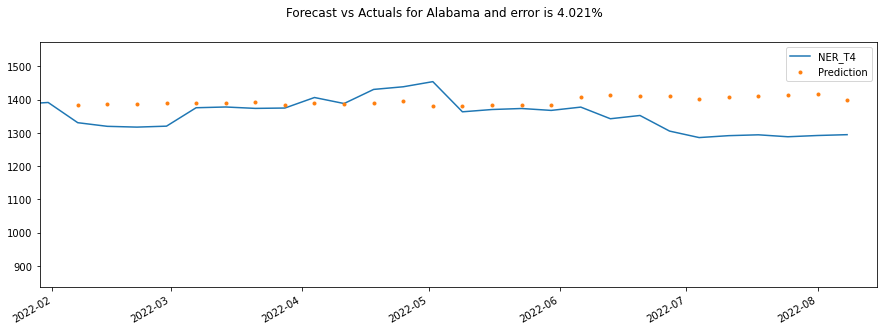

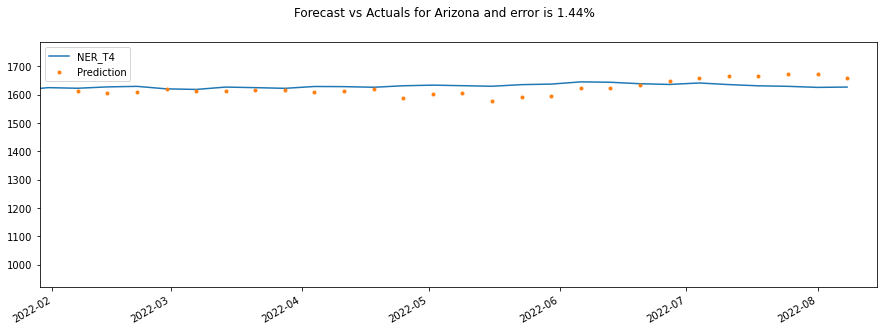

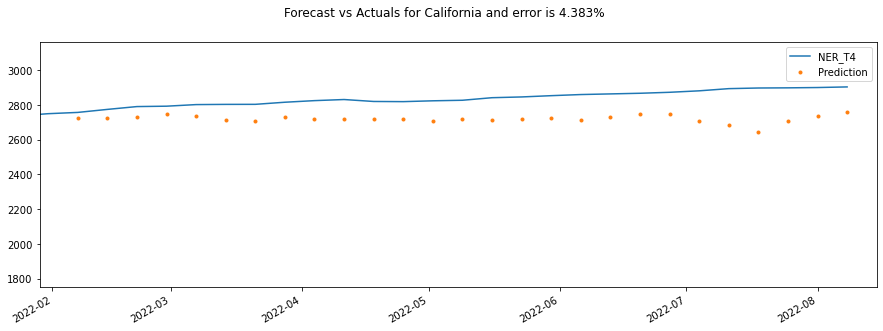

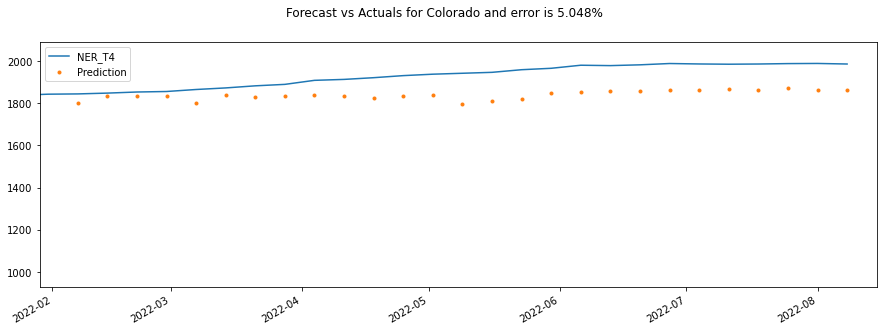

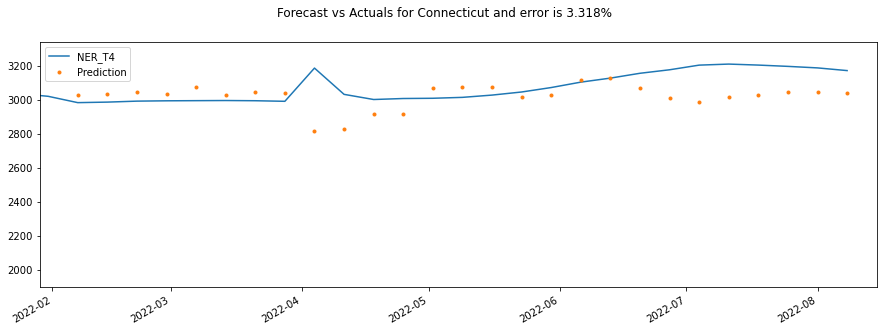

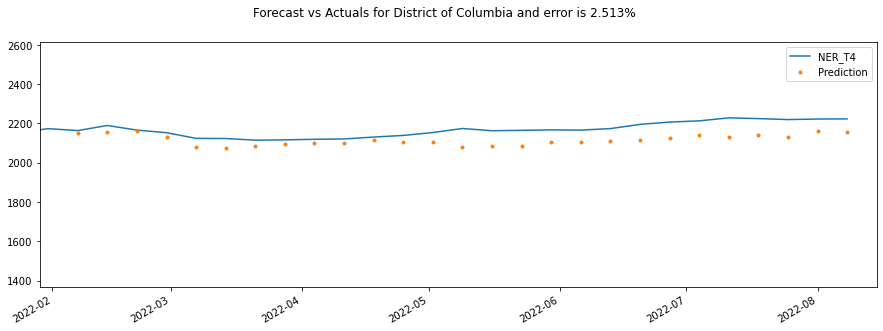

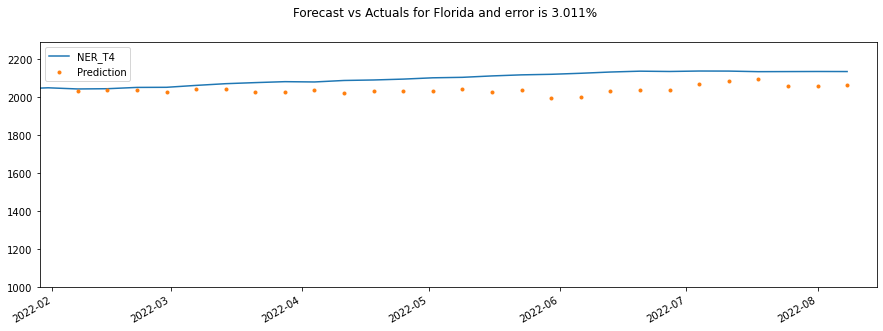

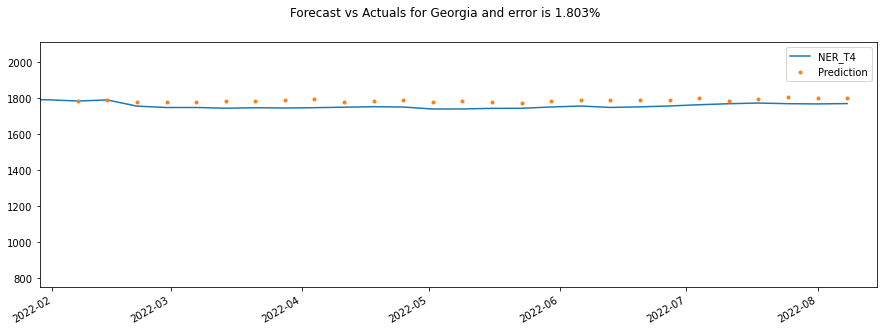

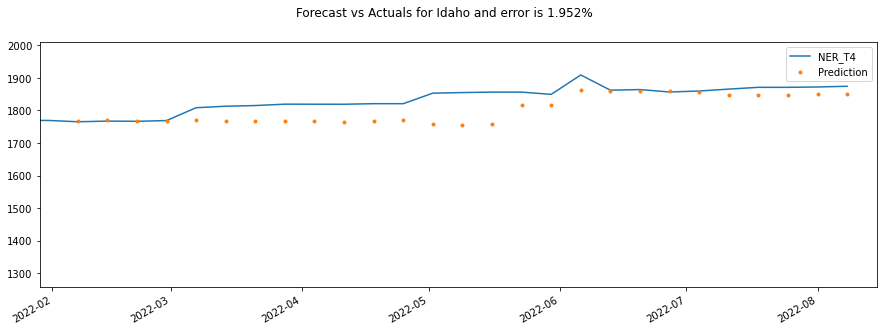

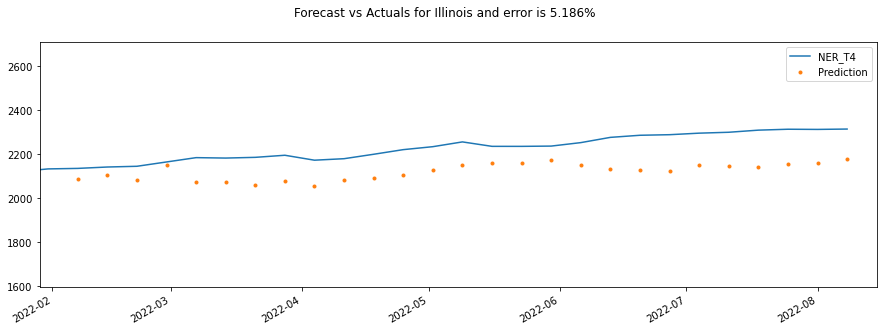

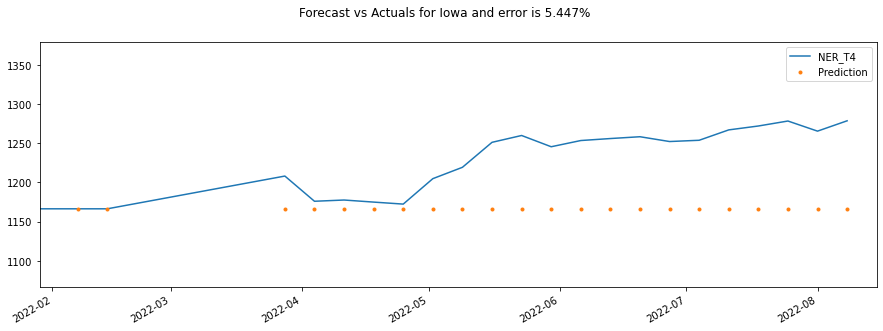

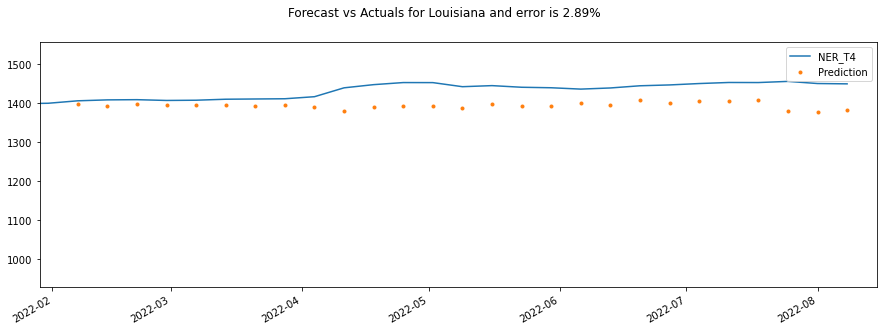

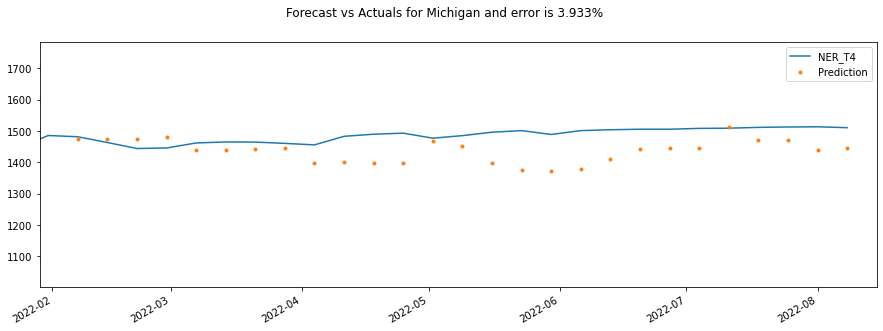

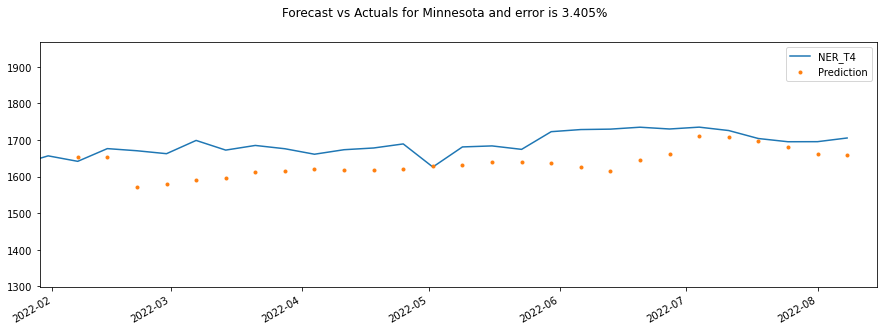

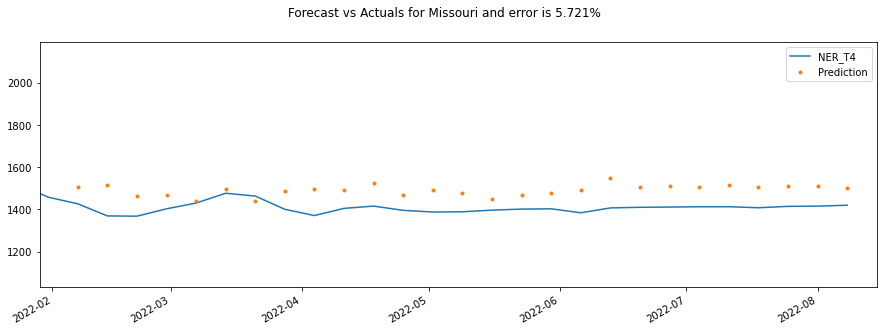

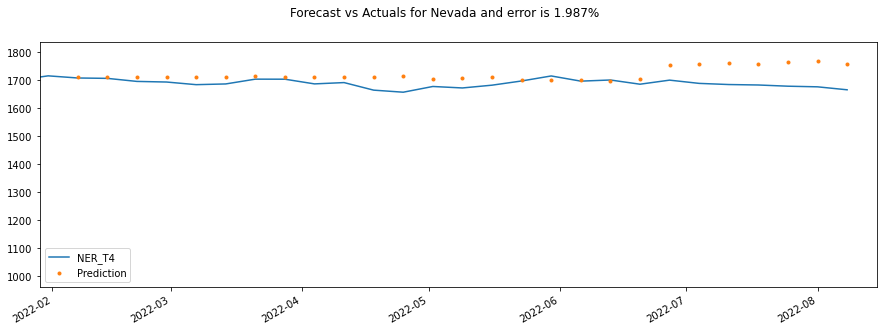

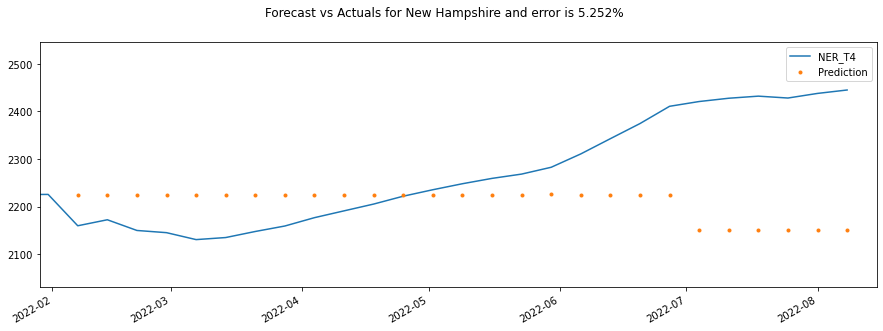

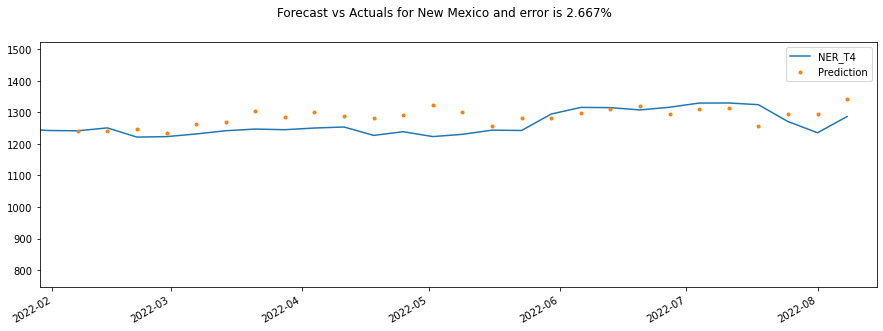

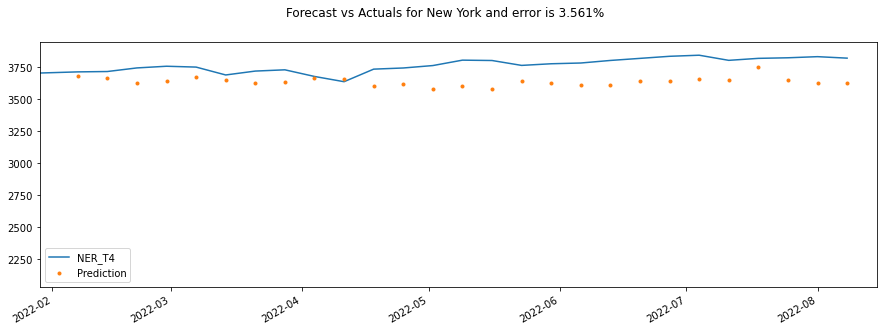

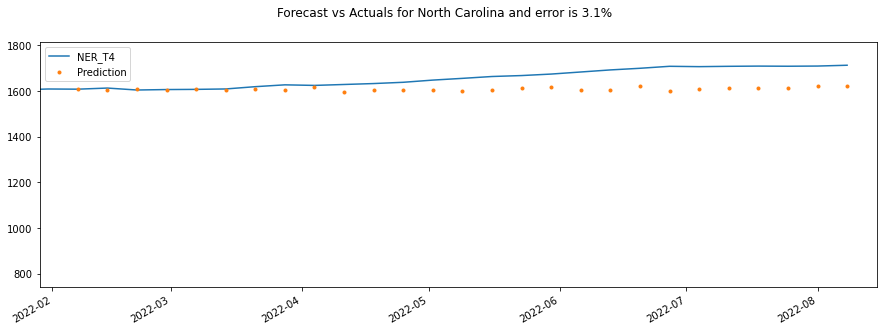

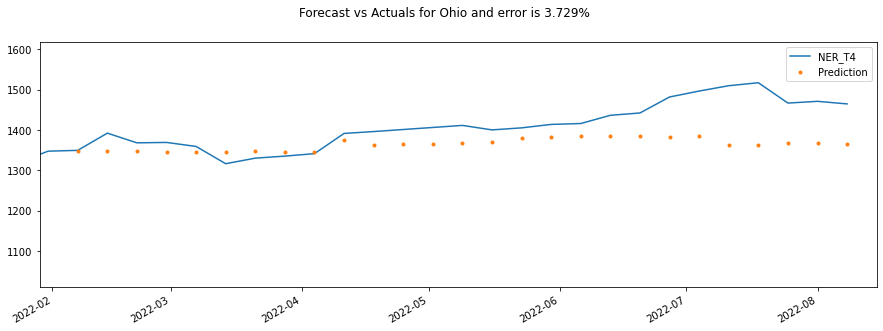

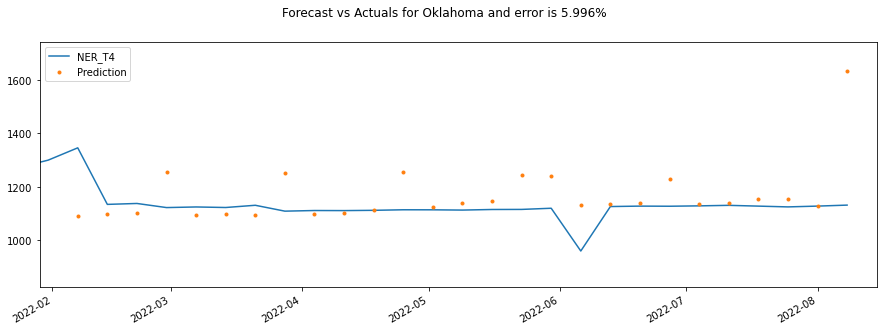

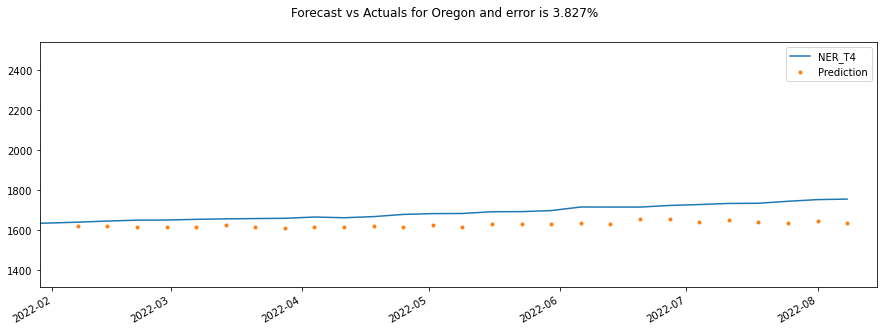

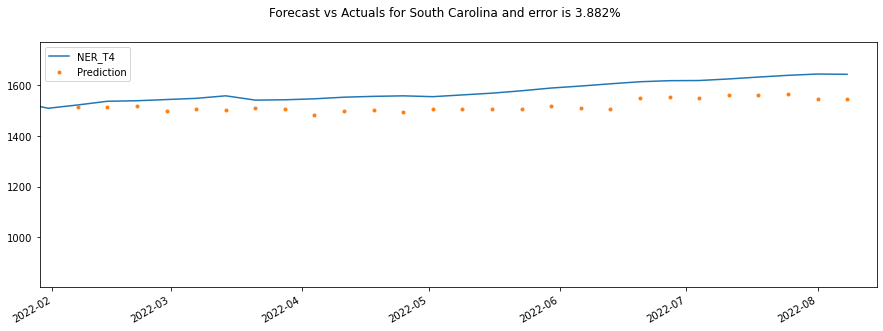

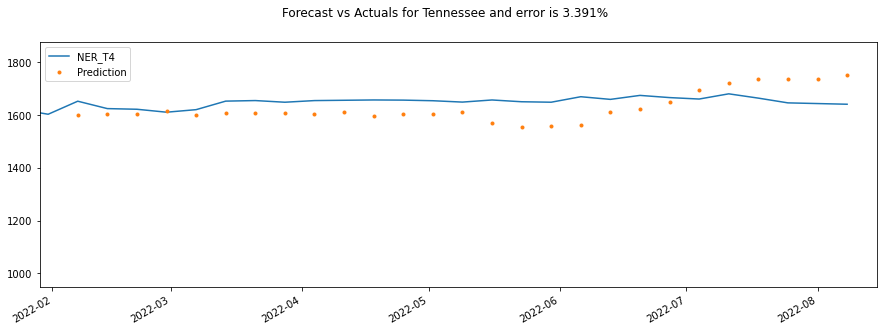

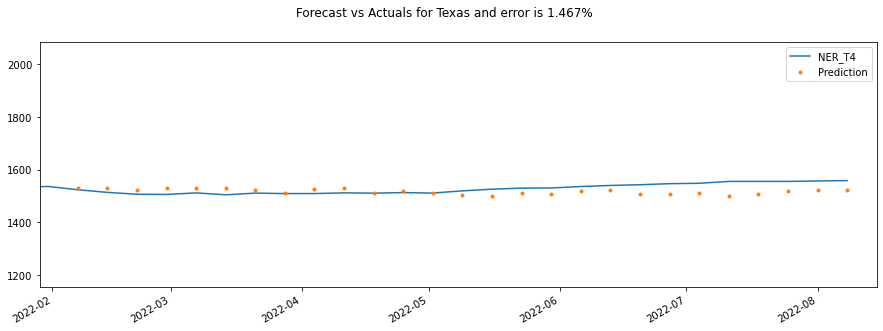

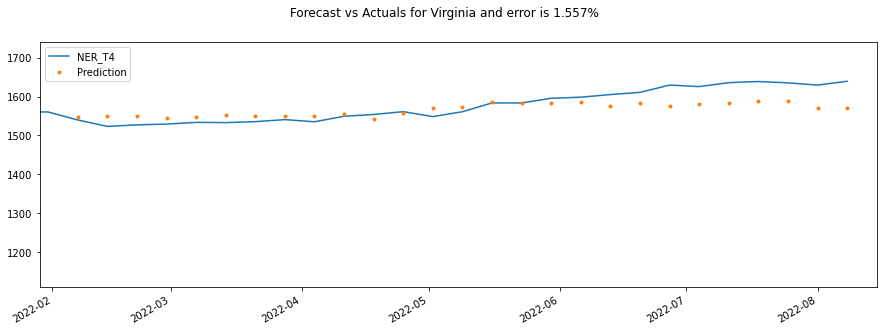

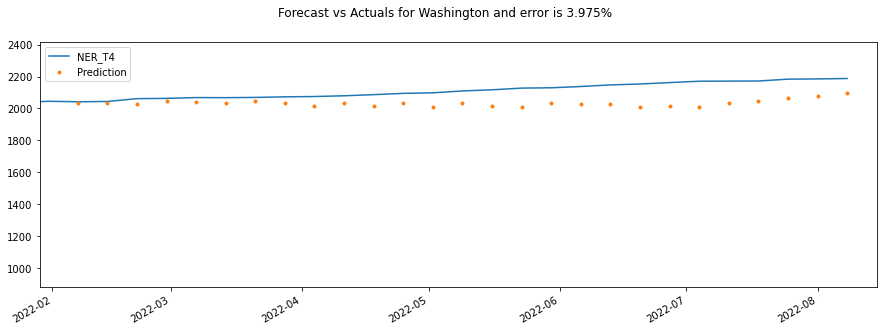

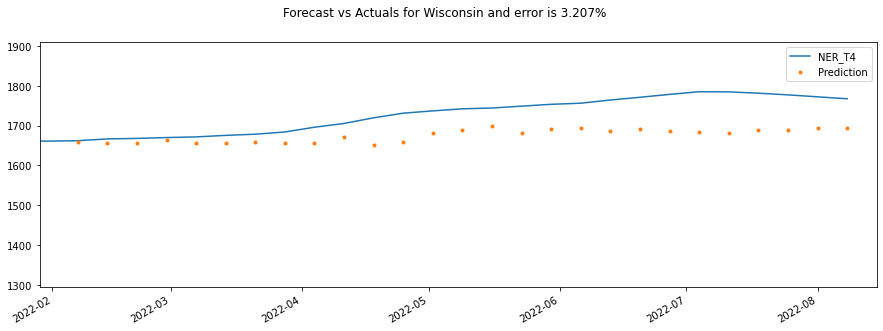

In [37]:
for unique_val, subset in subsets.items():
    split_date = date(2022, 2, 1)
    subset['date'] = subset.index
    df_train = subset.loc[subset.index <= split_date].copy()
    df_test = subset.loc[subset.index > split_date].copy()
    df_train = datetime_index(df_train, 'date')
    df_test = datetime_index(df_test, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    
    X_test, y_test = create_features(df_test, label='NER_T4')
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

    if mape < 0.06:
        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


        ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
        ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

In [38]:
prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
prediction_period = prediction_period.rename(columns = {0:'date'})
prediction_period

,date
0,2022-08-14
1,2022-08-21
2,2022-08-28
3,2022-09-04
4,2022-09-11
5,2022-09-18
6,2022-09-25
7,2022-10-02
8,2022-10-09
9,2022-10-16


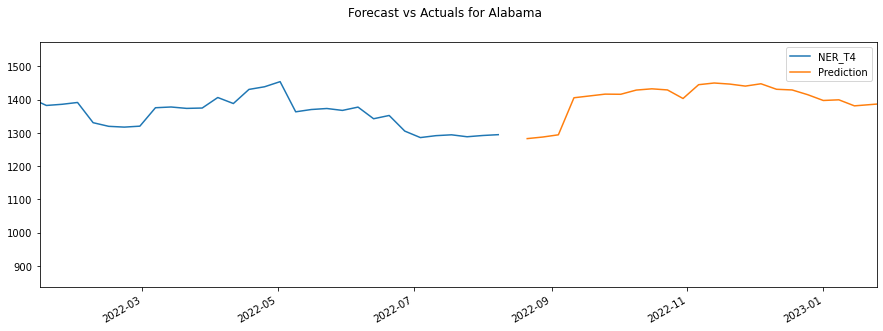

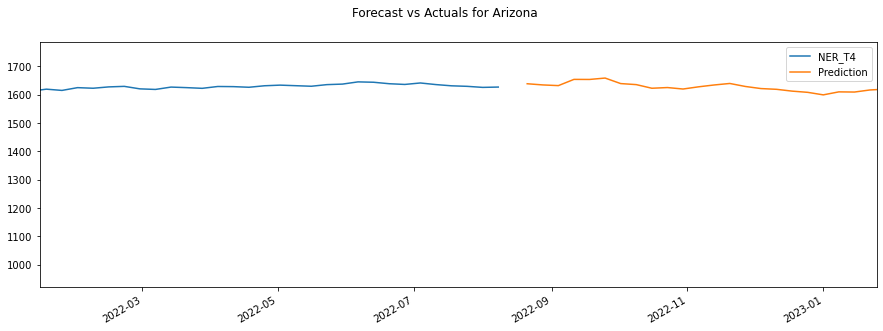

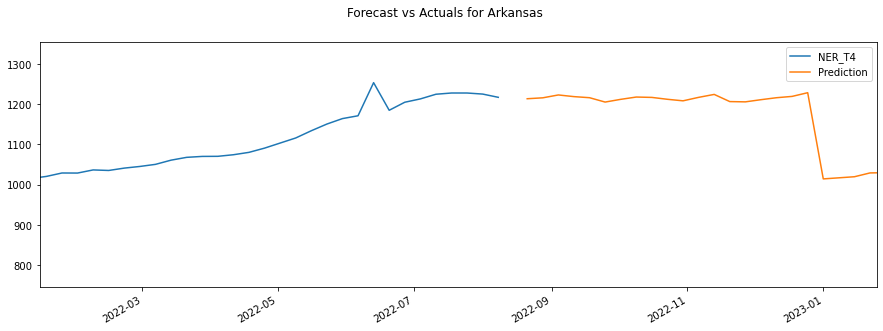

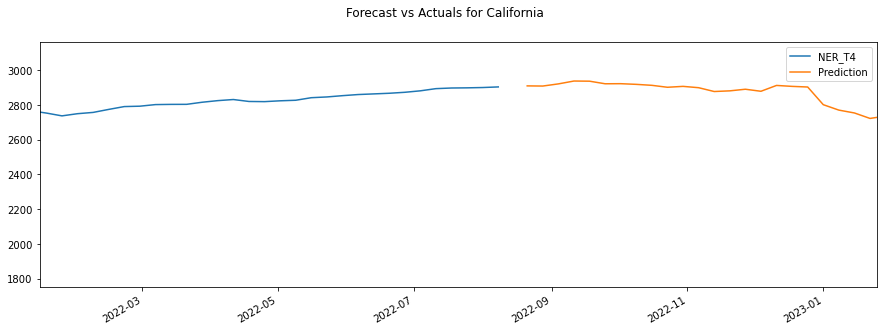

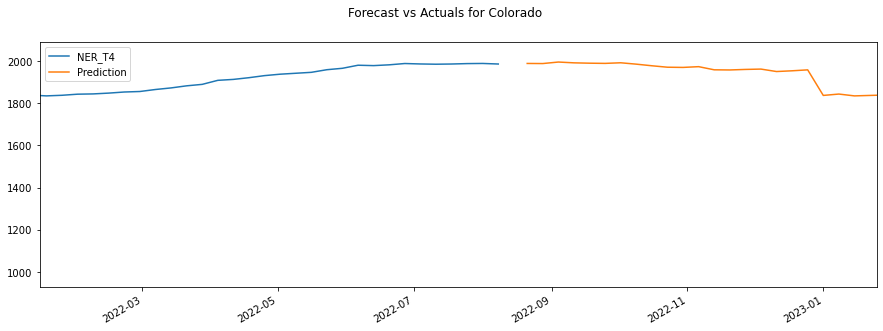

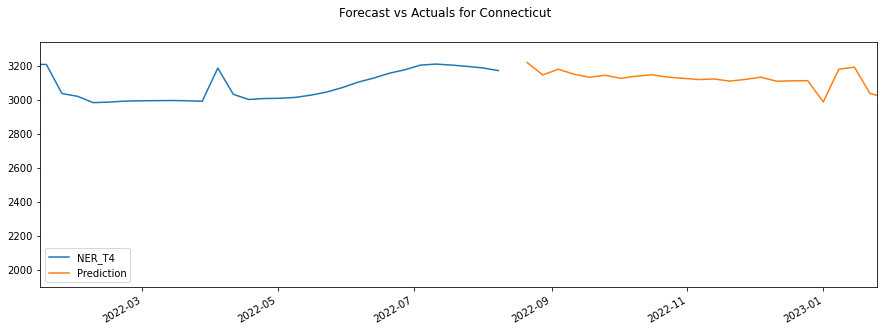

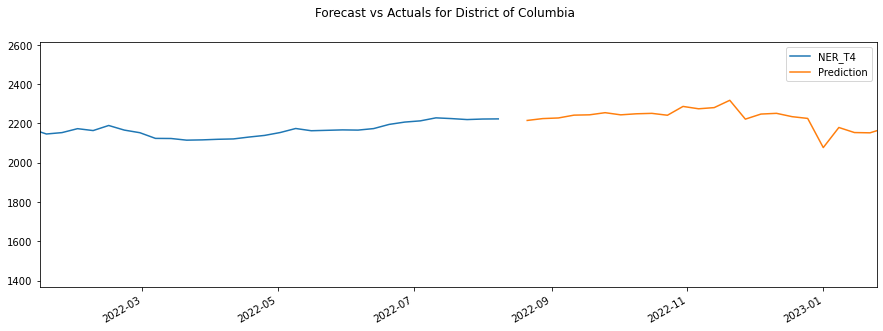

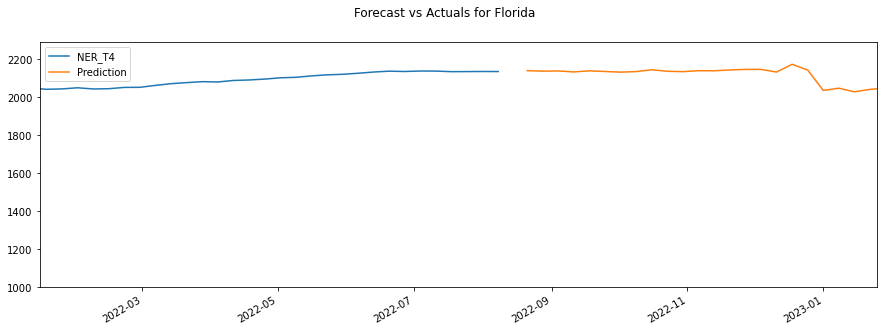

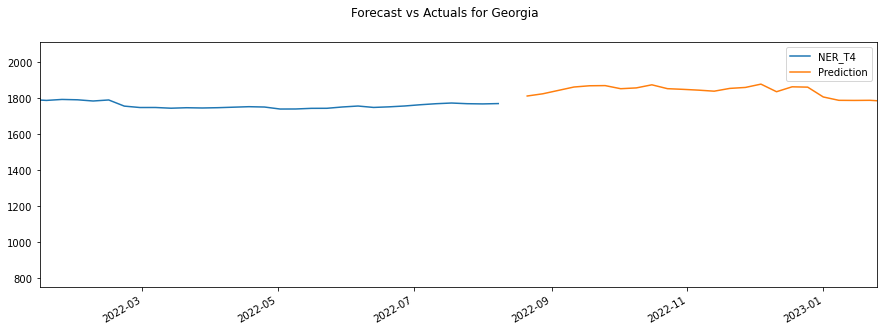

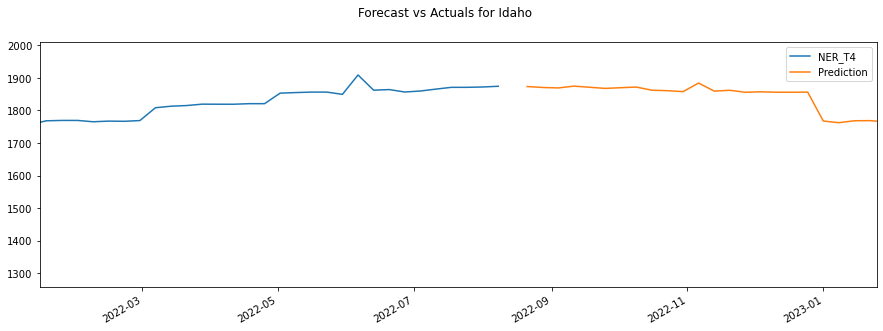

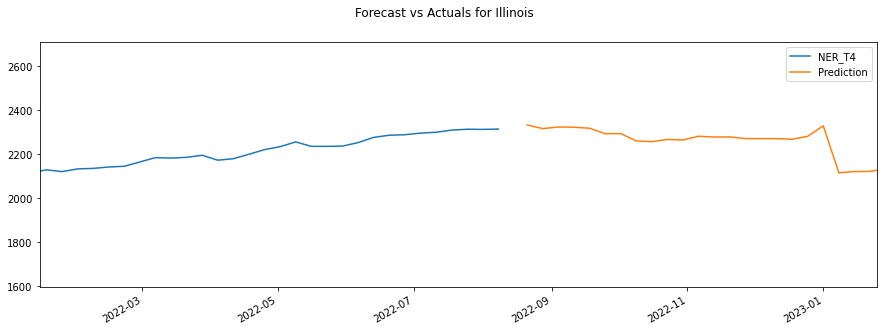

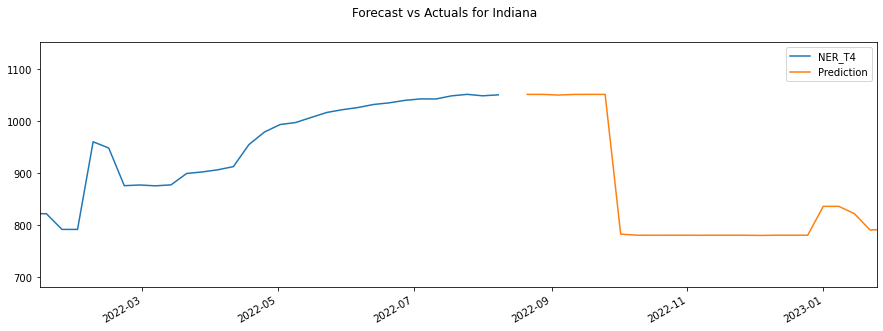

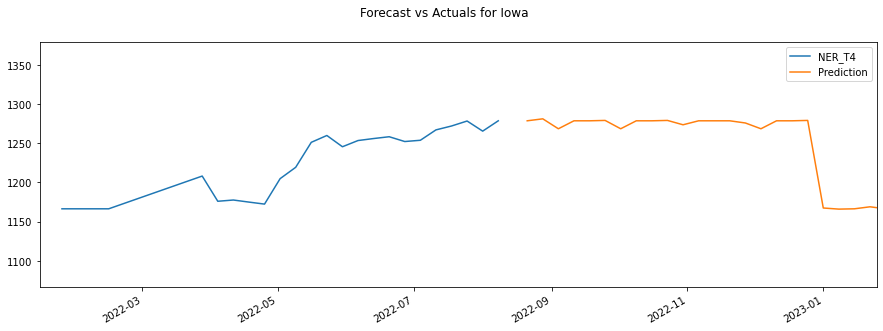

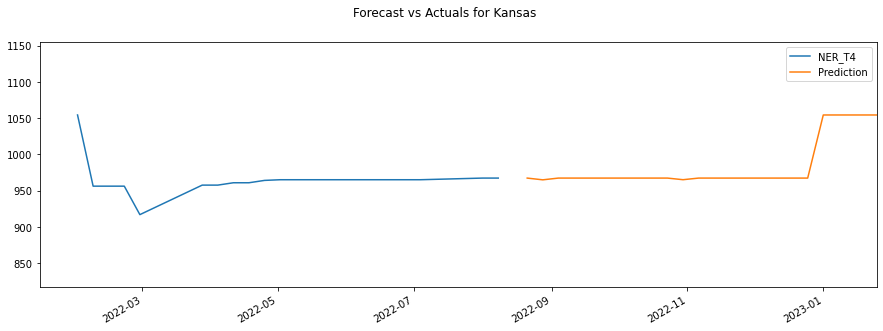

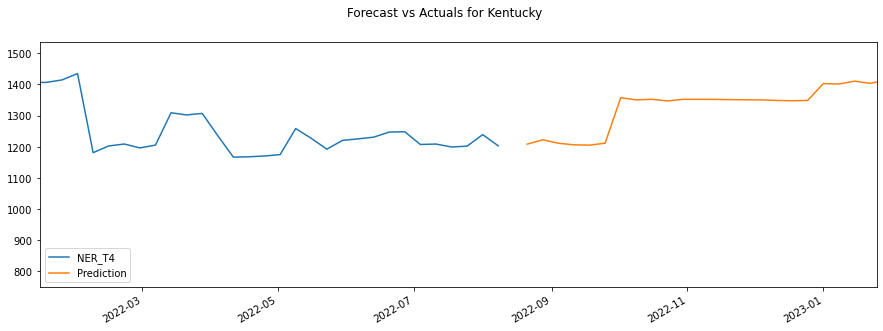

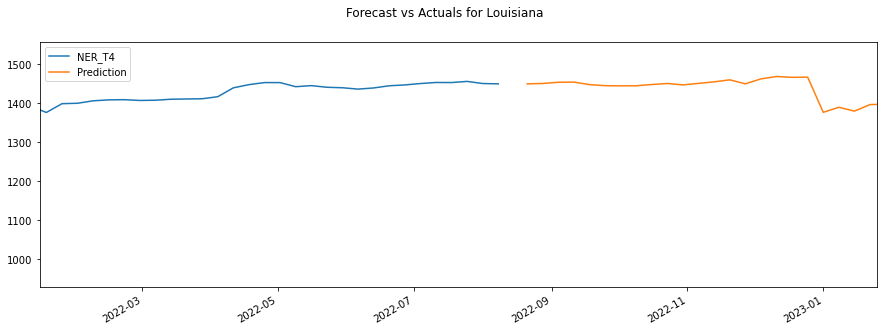

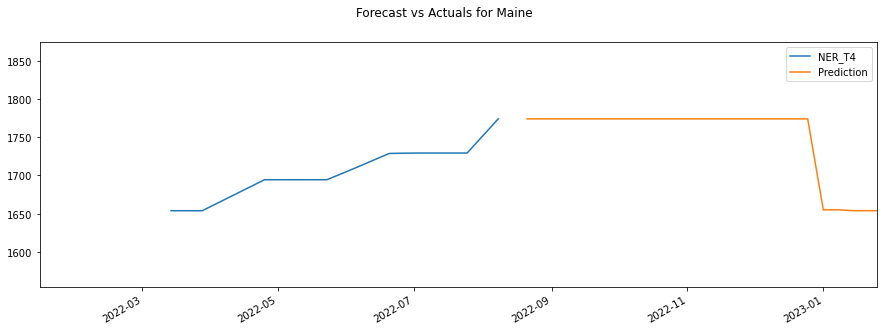

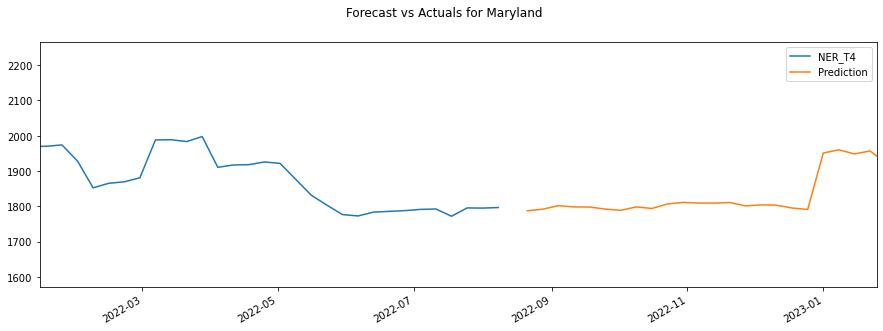

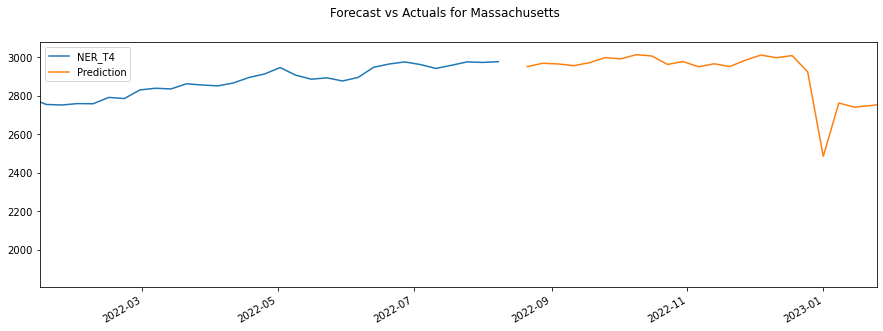

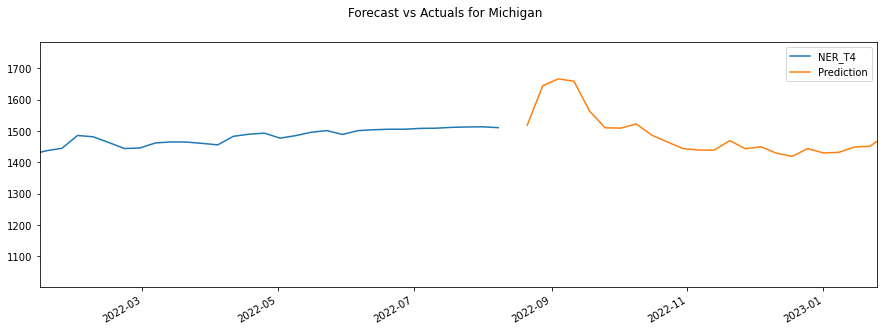

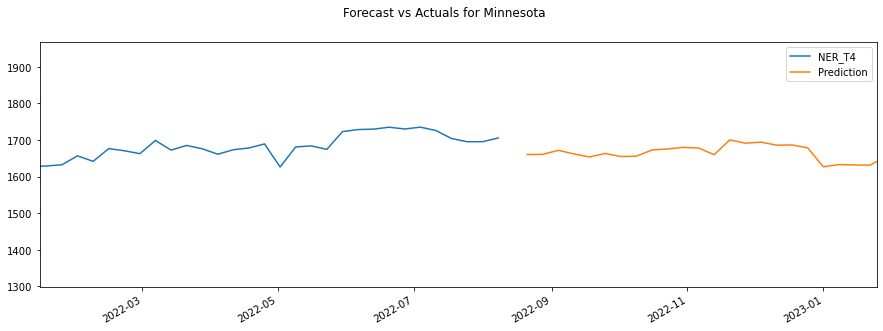

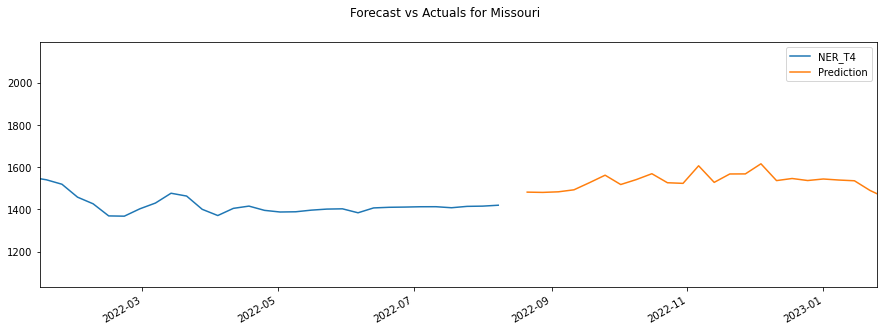

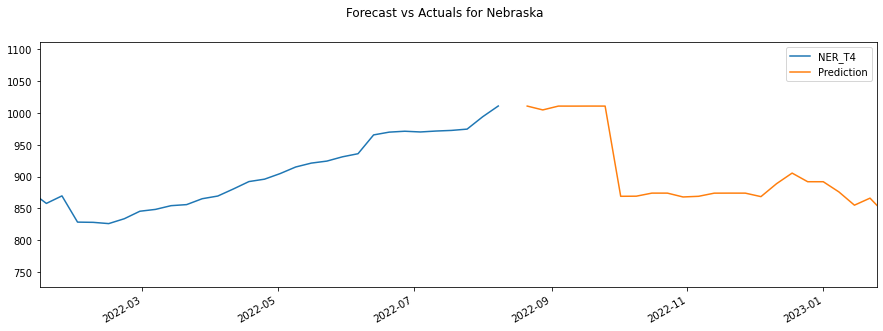

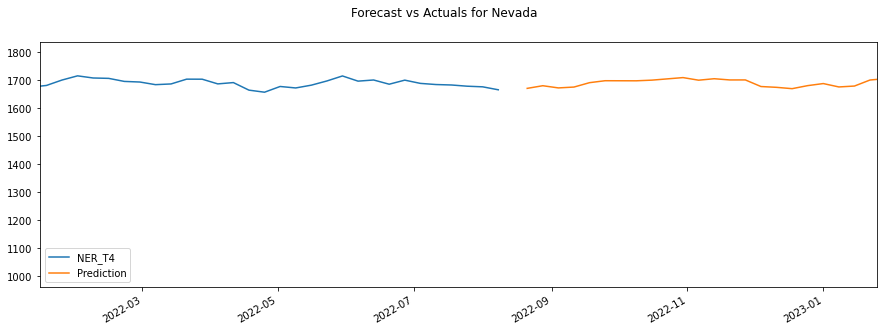

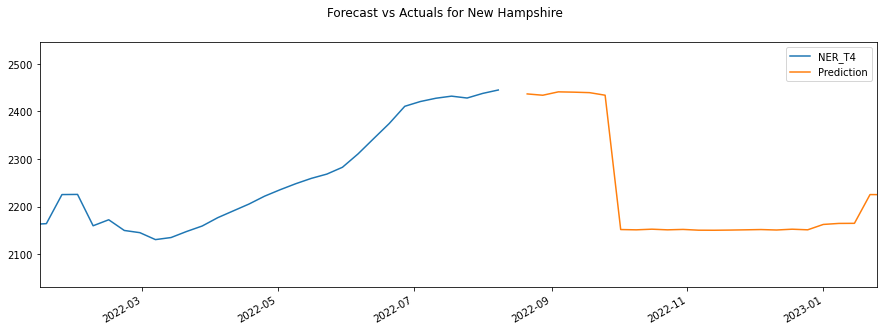

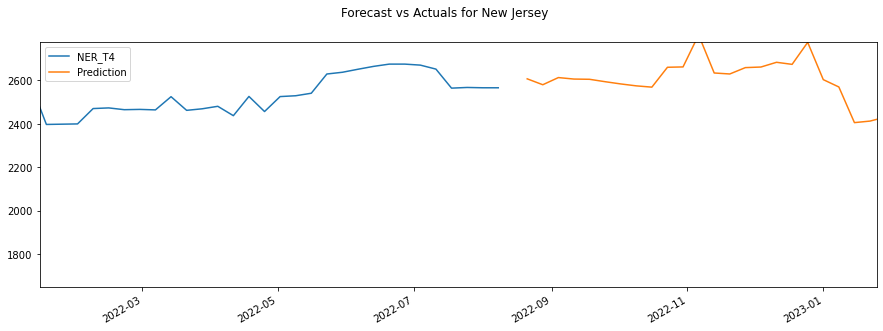

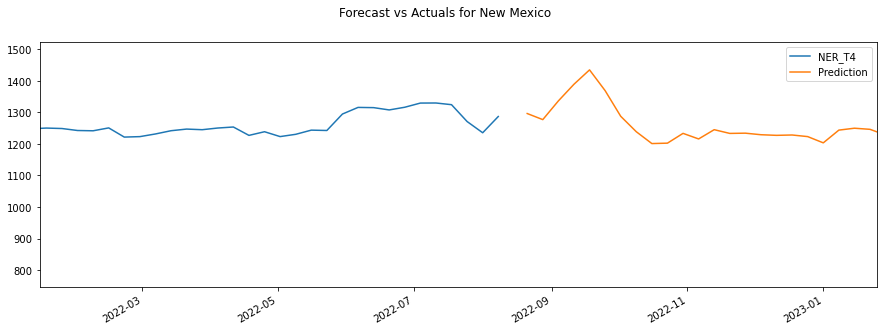

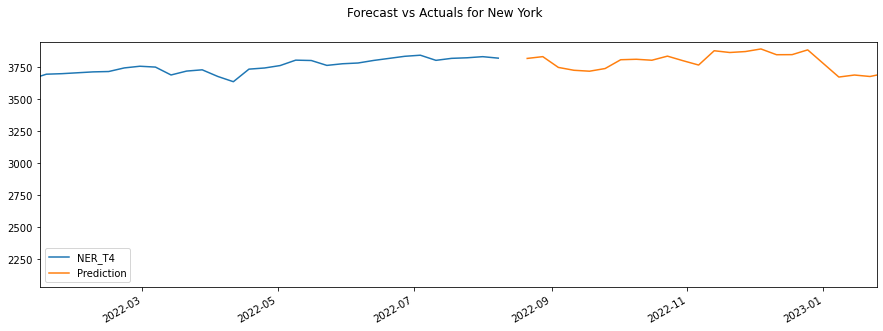

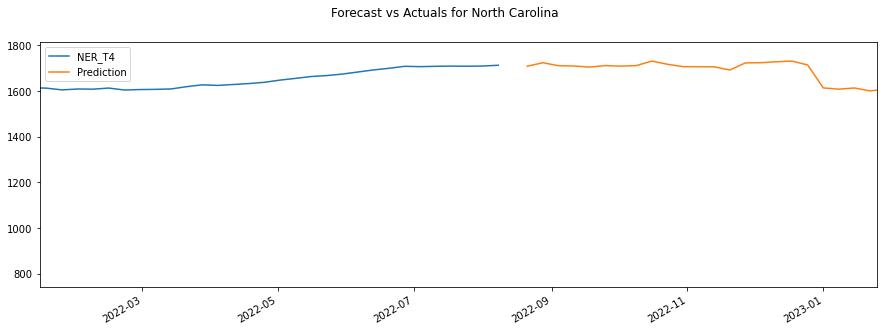

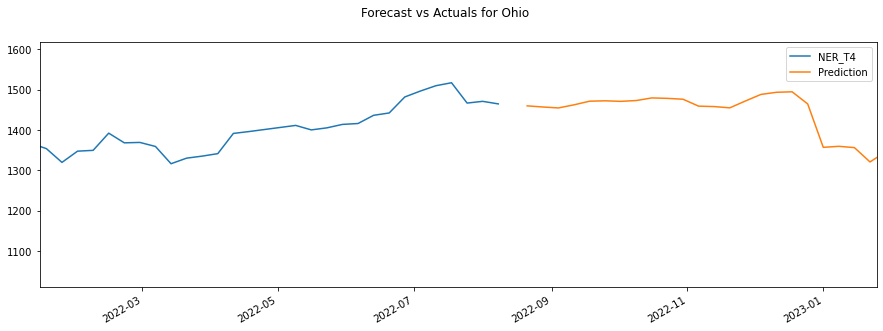

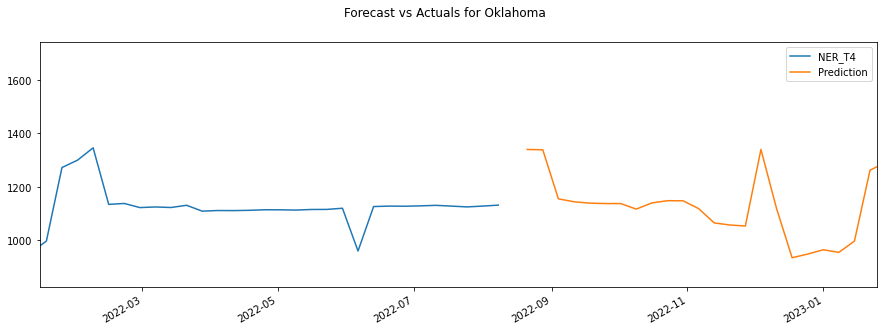

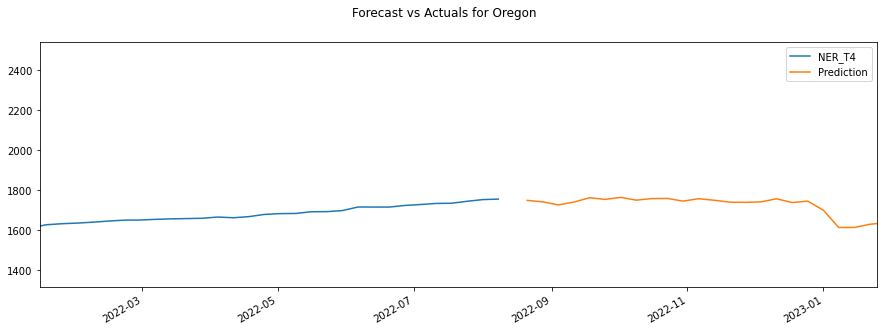

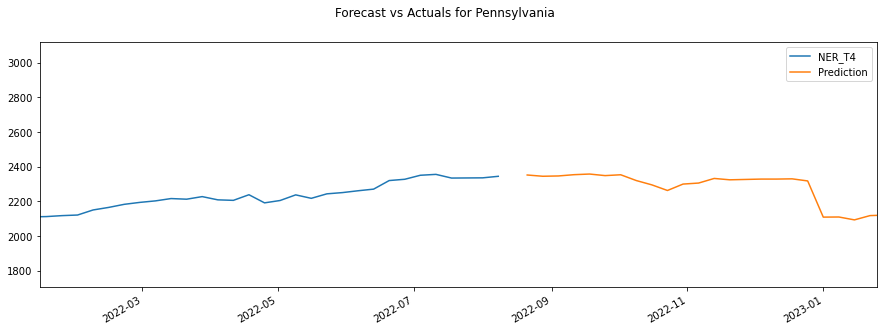

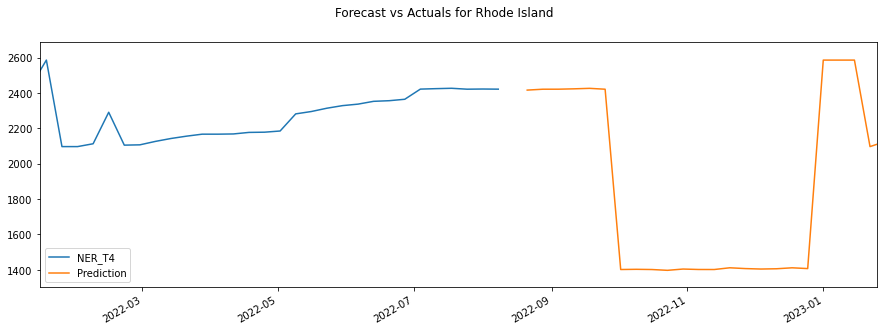

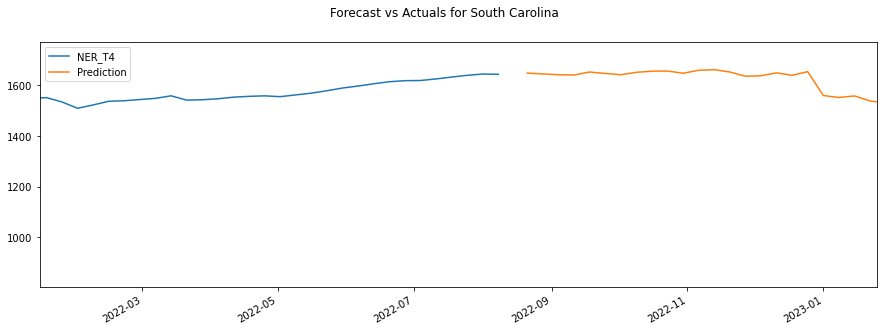

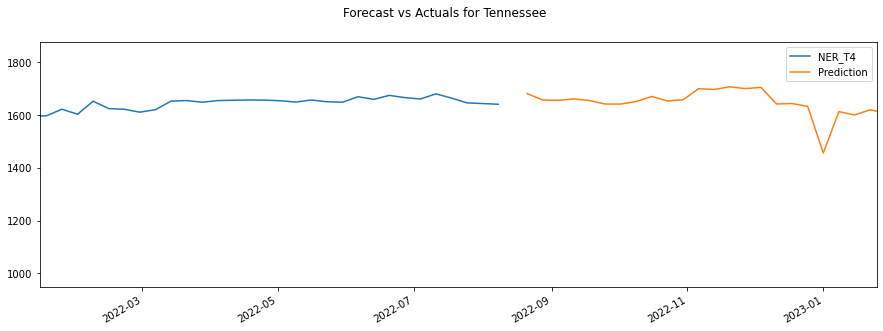

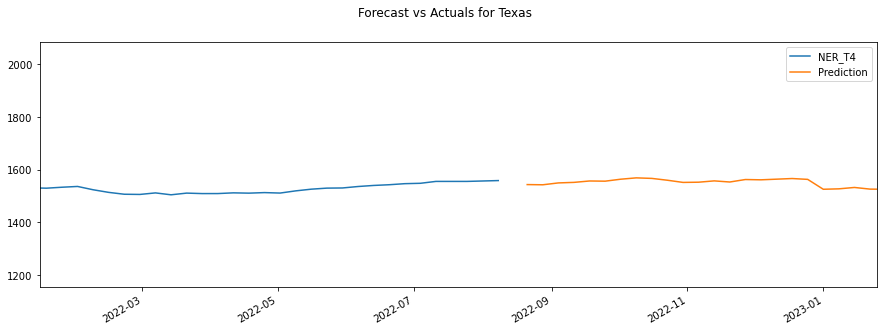

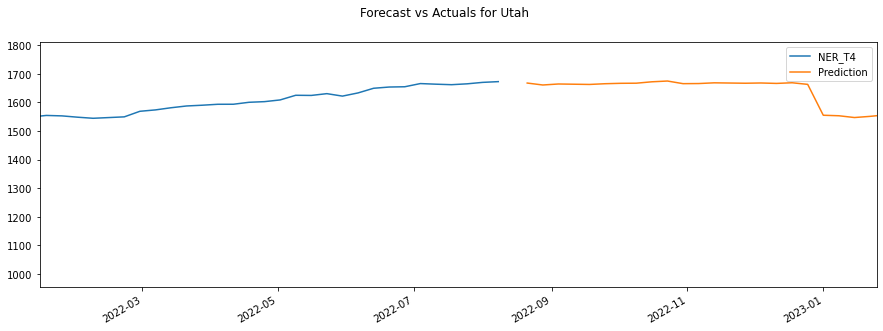

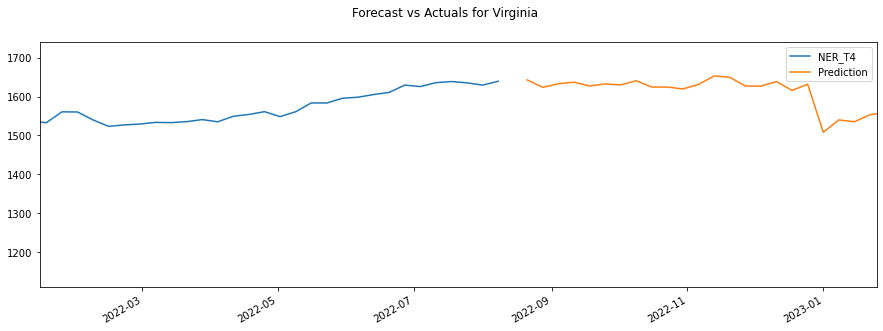

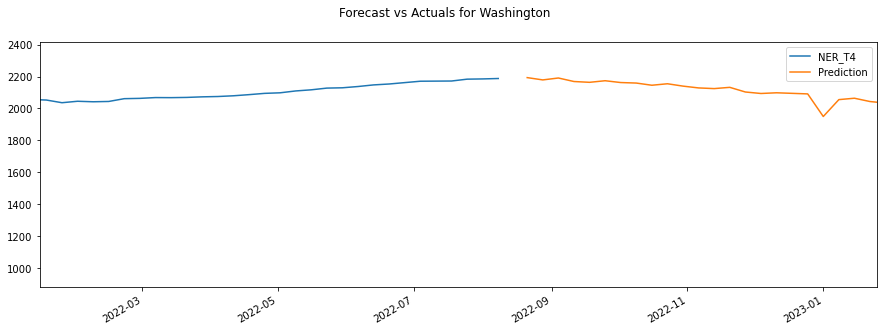

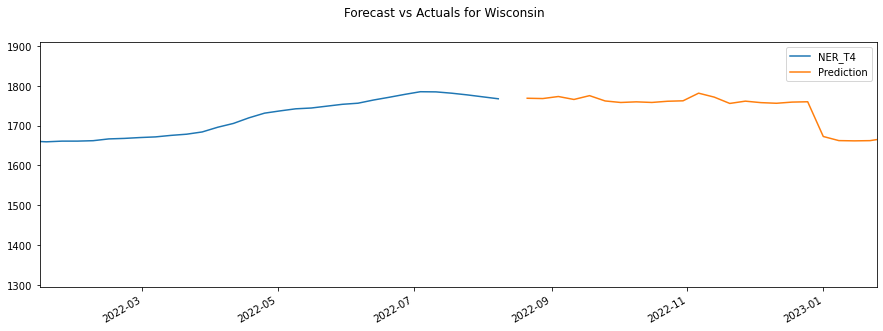

In [40]:
for unique_val, subset in subsets.items():
    subset['date'] = subset.index
    df_train = subset
    df_train = datetime_index(df_train, 'date')
    X_train, y_train = create_features(df_train, label='NER_T4')
    
    
    prediction_period = pd.DataFrame(pd.date_range('2022-08-15', periods=24, freq='W'))
    prediction_period = prediction_period.rename(columns = {0:'date'})
    df_test = datetime_index(prediction_period, 'date')

    
    X_test = create_features(df_test)
    
    
    reg = xgb.XGBRegressor(n_estimators=200)
    
    reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train)],
        early_stopping_rounds=50,
       verbose=False)     
    
    df_test['Prediction'] = reg.predict(X_test)
    df_all = pd.concat([df_test, df_train], sort=False)
    
    
    f, ax = plt.subplots(1)
    f.set_figheight(5)
    f.set_figwidth(15)
    _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','-'])


    ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
    ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

    plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')

In [41]:
df_test.reset_index()['index']

0    2022-08-21
1    2022-08-28
2    2022-09-04
3    2022-09-11
4    2022-09-18
5    2022-09-25
6    2022-10-02
7    2022-10-09
8    2022-10-16
9    2022-10-23
10   2022-10-30
11   2022-11-06
12   2022-11-13
13   2022-11-20
14   2022-11-27
15   2022-12-04
16   2022-12-11
17   2022-12-18
18   2022-12-25
19   2023-01-01
20   2023-01-08
21   2023-01-15
22   2023-01-22
23   2023-01-29
Name: index, dtype: datetime64[ns]

In [42]:
msa_data = pd.read_csv('msa_data.csv')
msa_data_lst = list(msa_data['MSA'])
msa_data_lst

['Atlanta, GA',
 'Austin, TX',
 'Baltimore, MD',
 'Boston, MA',
 'Charleston, SC',
 'Charlotte, NC',
 'Chicago, IL',
 'Dallas, TX',
 'Denver, CO',
 'Houston, TX',
 'Jacksonville, FL',
 'Las Vegas, NV',
 'Los Angeles, CA',
 'Miami, FL',
 'Nashville, TN',
 'New York, NY',
 'Orlando, FL',
 'Phoenix, AZ',
 'Portland, OR',
 'Raleigh, NC',
 'Riverside, CA',
 'San Antonio, TX',
 'San Diego, CA',
 'San Francisco, CA',
 'San Jose, CA',
 'Seattle, WA',
 'Tampa, FL',
 'Washington, DC']

In [43]:
subsets = dict((x, y) for x, y in raot_cta_ner.groupby(['MSA']))

for unique_val, subset in subsets.items():
    subsets[unique_val] = subset.groupby('WEEK_START').mean('NER')

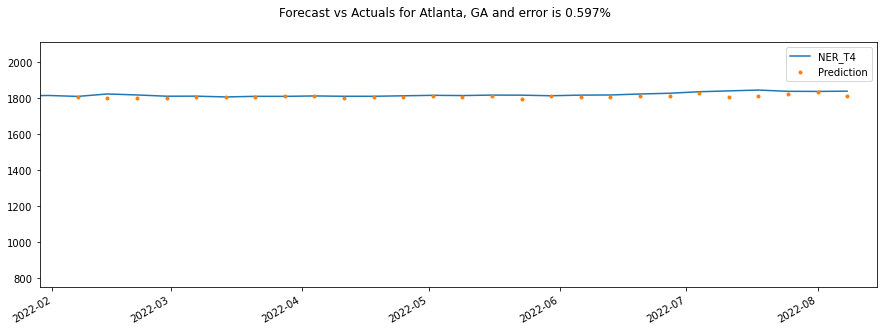

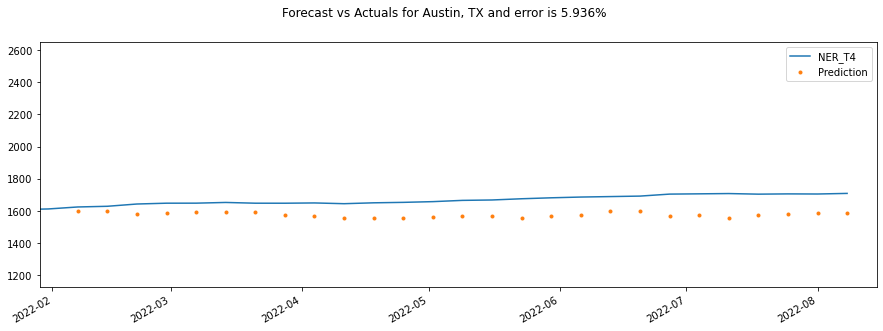

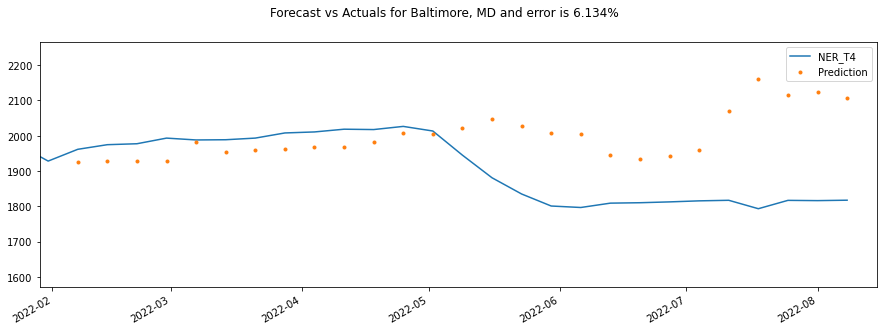

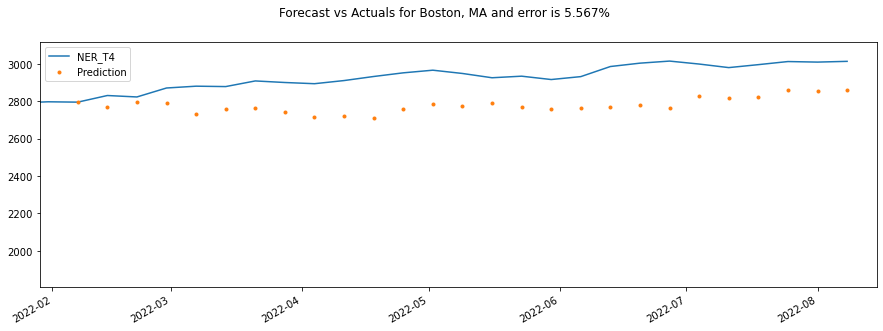

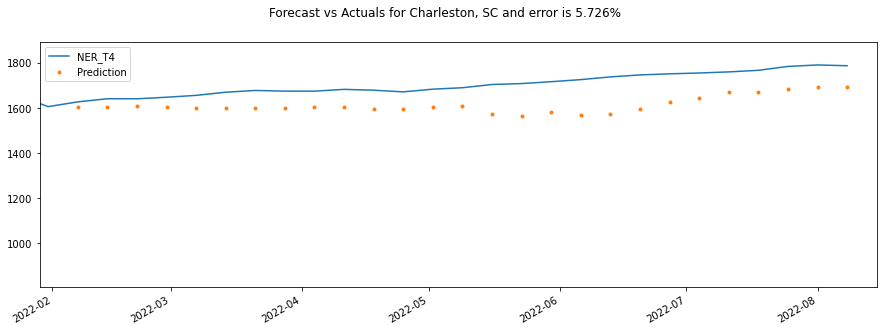

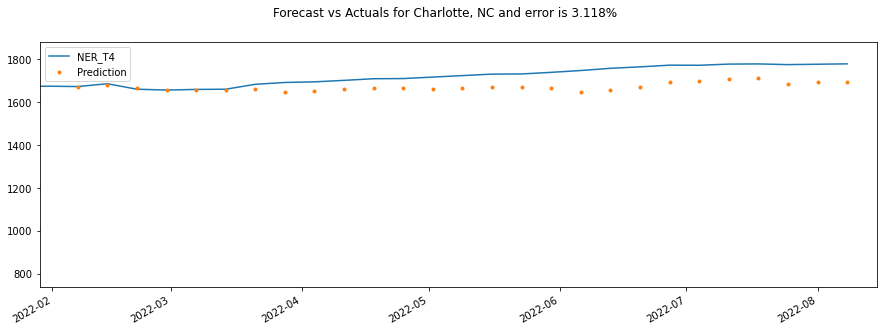

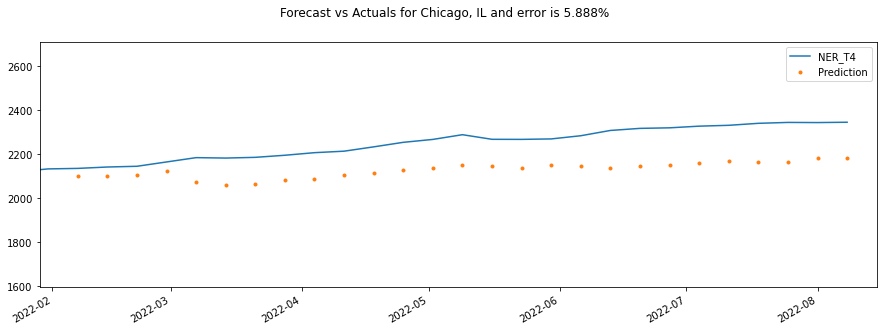

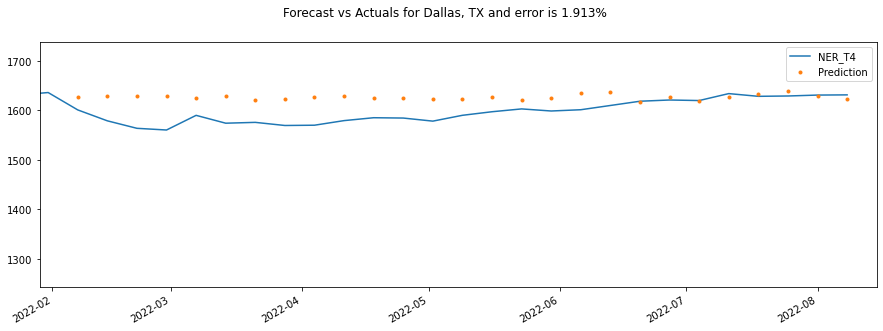

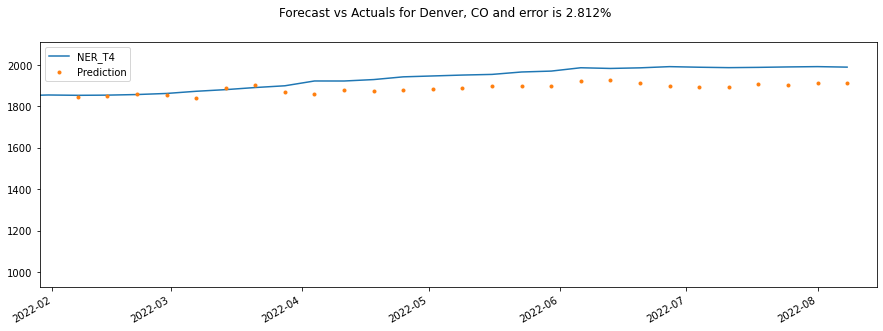

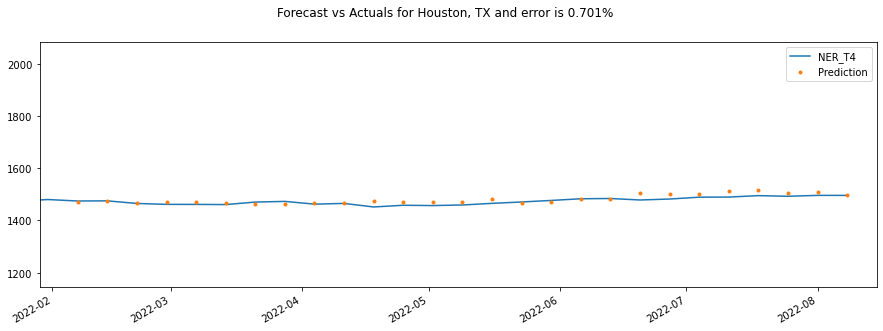

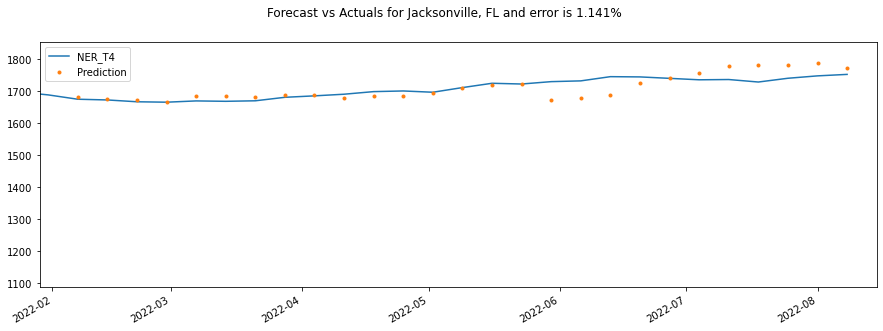

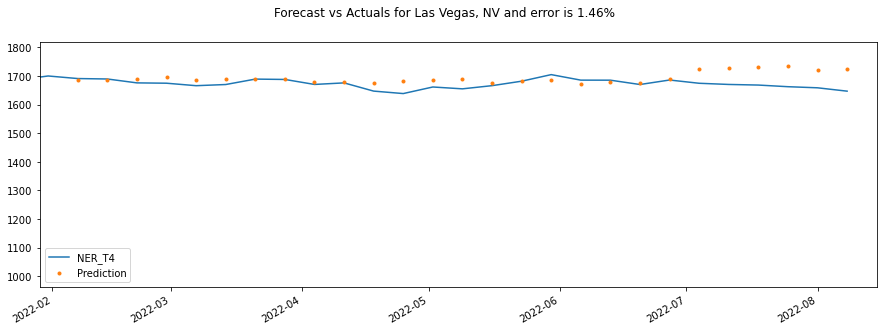

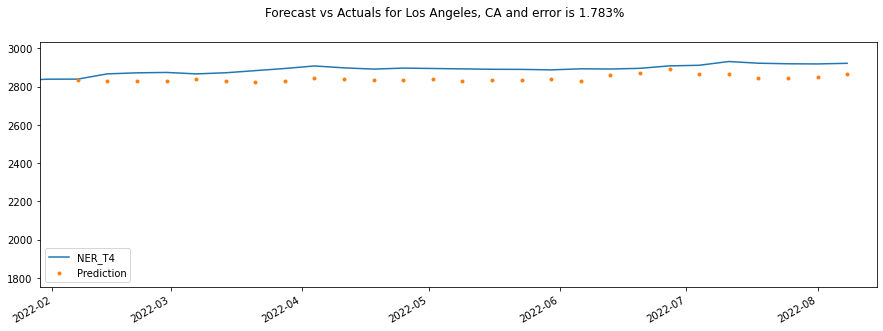

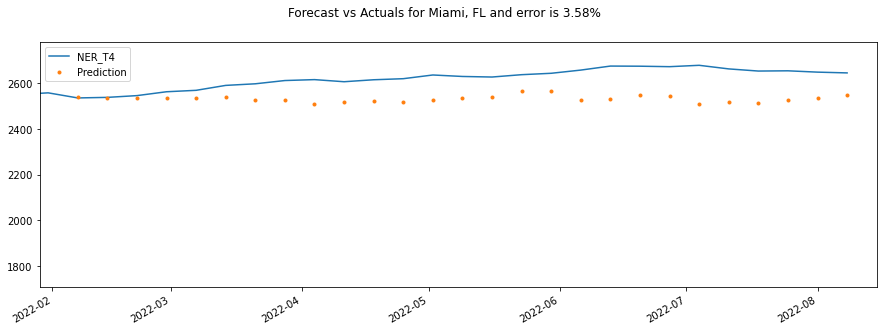

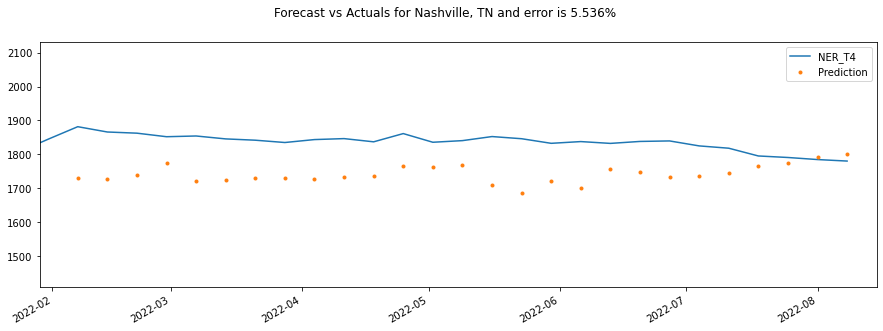

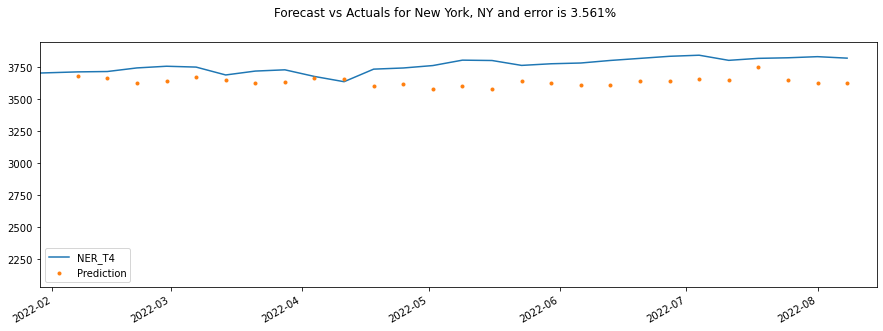

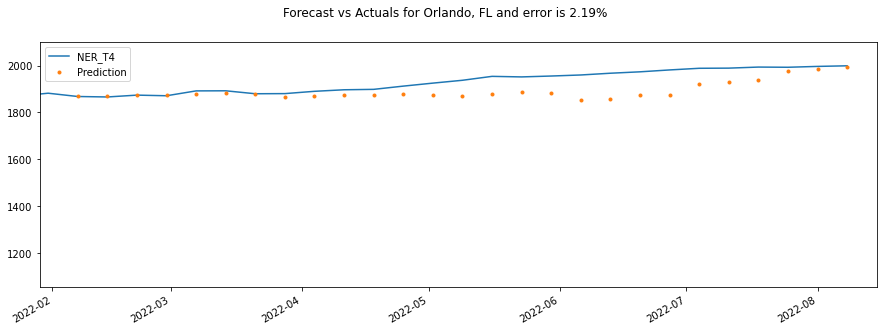

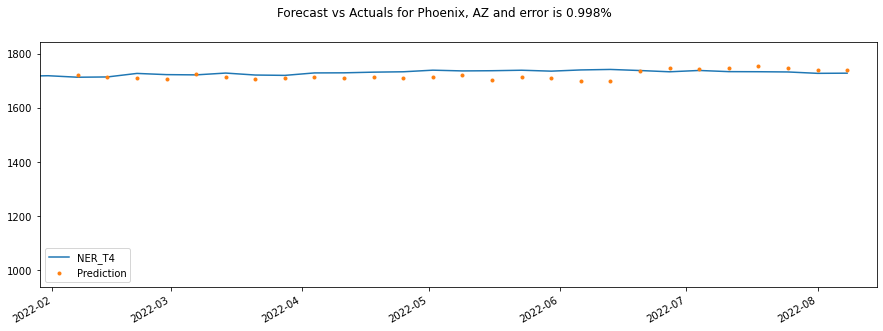

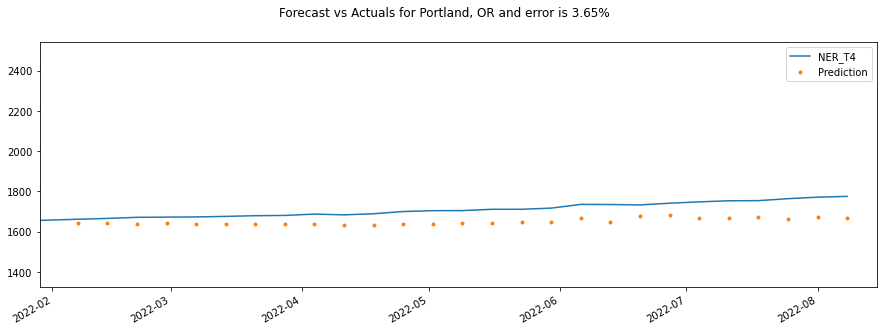

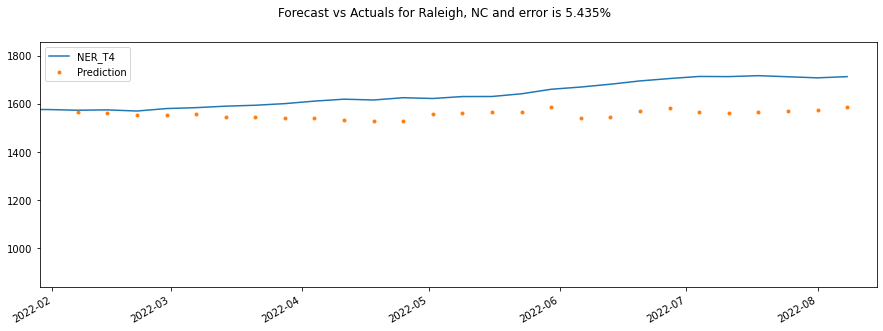

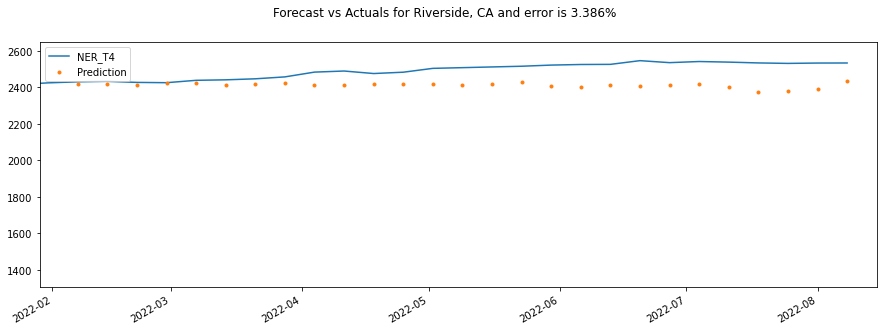

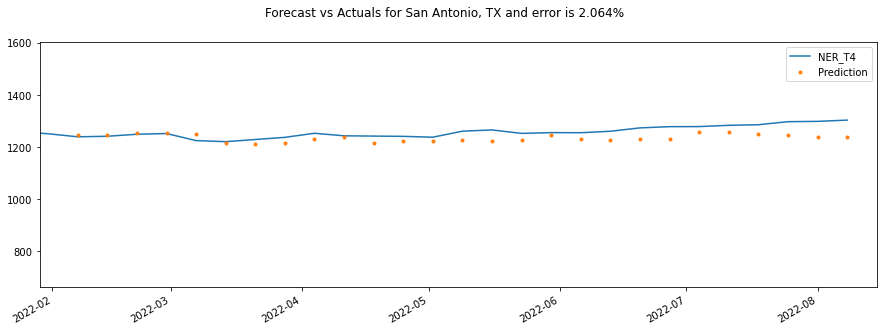

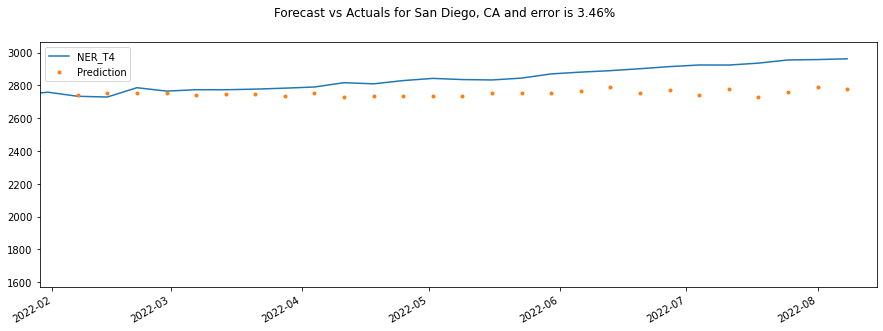

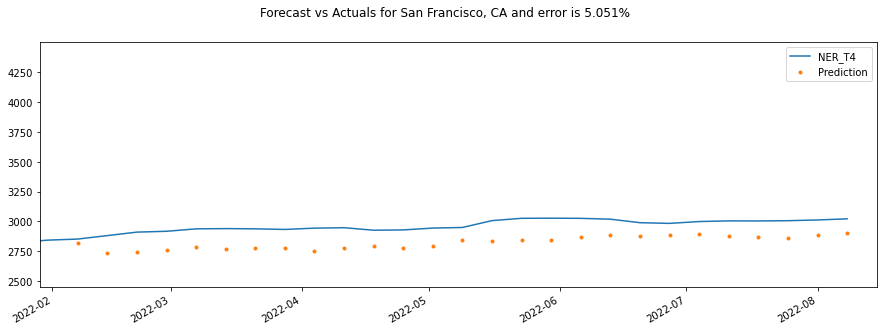

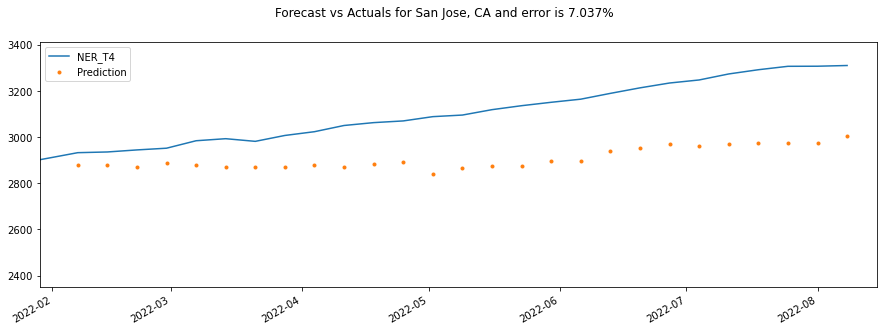

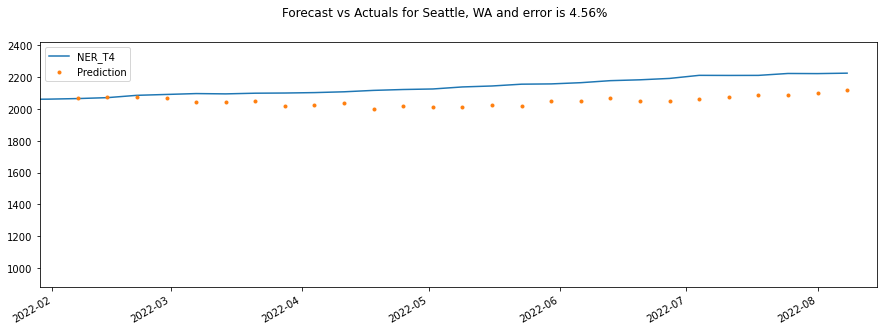

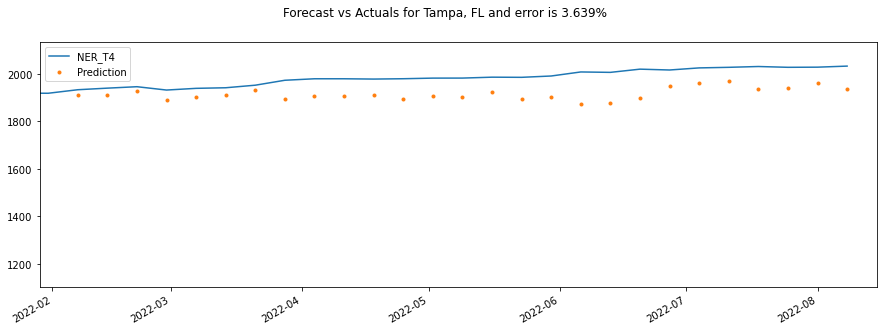

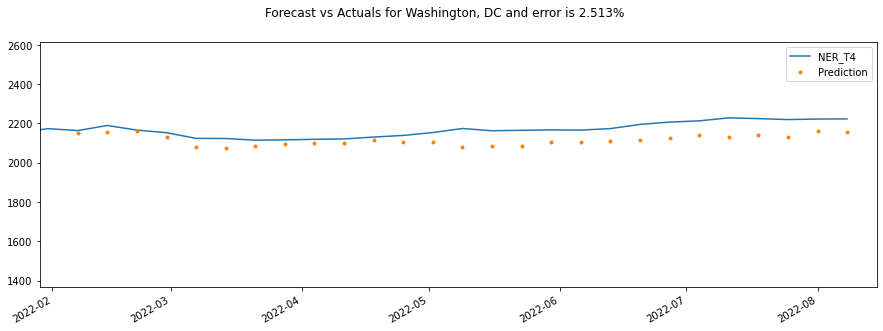

In [44]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        split_date = date(2022, 2, 1)
        subset['date'] = subset.index
        df_train = subset.loc[subset.index <= split_date].copy()
        df_test = subset.loc[subset.index > split_date].copy()
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        X_train, y_train = create_features(df_train, label='NER_T4')

        X_test, y_test = create_features(df_test, label='NER_T4')
        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape = evaluation(df_test['NER_T4'], df_test['Prediction'])

        if mape < 0.10:
            f, ax = plt.subplots(1)
            f.set_figheight(5)
            f.set_figwidth(15)
            _ = df_all[['NER_T4','Prediction']].plot(ax=ax, style=['-','.'])


            ax.set_xbound(lower='01-29-2022', upper='08-15-2022')
            ax.set_ylim(min(subset['NER_T4'])-100,max(subset['NER_T4'])+100)

            plot = plt.suptitle(f'Forecast vs Actuals for {unique_val} and error is {round(mape*100,3)}%')

**Extracting the data into a df**

In [45]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
        print(unique_val)
        print(subset.tail(25))

Atlanta, GA
                 NER_T4        date
WEEK_START                         
2022-02-21  1817.138120  2022-02-21
2022-02-28  1810.117232  2022-02-28
2022-03-07  1810.411329  2022-03-07
2022-03-14  1806.048010  2022-03-14
2022-03-21  1809.502624  2022-03-21
2022-03-28  1809.268808  2022-03-28
2022-04-04  1811.530520  2022-04-04
2022-04-11  1809.755084  2022-04-11
2022-04-18  1809.741514  2022-04-18
2022-04-25  1812.235026  2022-04-25
2022-05-02  1815.014586  2022-05-02
2022-05-09  1813.710384  2022-05-09
2022-05-16  1816.333274  2022-05-16
2022-05-23  1815.906064  2022-05-23
2022-05-30  1812.647317  2022-05-30
2022-06-06  1816.187131  2022-06-06
2022-06-13  1816.941686  2022-06-13
2022-06-20  1822.362223  2022-06-20
2022-06-27  1826.475887  2022-06-27
2022-07-04  1834.954781  2022-07-04
2022-07-11  1839.670629  2022-07-11
2022-07-18  1844.226534  2022-07-18
2022-07-25  1837.297729  2022-07-25
2022-08-01  1836.698252  2022-08-01
2022-08-08  1838.034501  2022-08-08
Austin, TX
     

In [46]:
column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

df_xgboost = pd.DataFrame(columns = column_names)
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score


In [48]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst:
    
    
        column_names = ["Model", "Time", "MSA", "Actuals", "Predictions", 'MAPE score']

        df = pd.DataFrame(columns = column_names)

                
        algorithm_name = 'XGBoost Model'
        
        ## experimenting with a dataset
        prediction_period = 25
        
        
        df_train = subset[:-prediction_period]
        df_test = subset[-prediction_period:]
        df_train = datetime_index(df_train, 'date')
        df_test = datetime_index(df_test, 'date')
        
        X_train, y_train = create_features(df_train, label='NER_T4')
        X_test, y_test = create_features(df_test, label='NER_T4')
        
        
        reg = xgb.XGBRegressor(n_estimators=500)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)

        mape_score = evaluation(df_test['NER_T4'], df_test['Prediction'])

                
        #print(df_test.reset_index()['index'])
        
        df['Actuals'] =  df_test['NER_T4']
        df['Predictions'] =  df_test['Prediction']
        df['MAPE score'] =  mape_score
        df['Time'] =  list(df_test.reset_index()['index'])
        df['Model'] =  algorithm_name
        df['MSA'] =  unique_val

        df_xgboost = df_xgboost.append(df, ignore_index=True)

In [50]:
df_xgboost

,Model,Time,MSA,Actuals,Predictions,MAPE score
0,XGBoost Model,2022-02-21,"Atlanta, GA",1817.138120,1810.588989,0.004530
1,XGBoost Model,2022-02-28,"Atlanta, GA",1810.117232,1809.112427,0.004530
2,XGBoost Model,2022-03-07,"Atlanta, GA",1810.411329,1808.625122,0.004530
3,XGBoost Model,2022-03-14,"Atlanta, GA",1806.048010,1814.297607,0.004530
4,XGBoost Model,2022-03-21,"Atlanta, GA",1809.502624,1807.149292,0.004530
...,...,...,...,...,...,...
695,XGBoost Model,2022-07-11,"Washington, DC",2227.980065,2170.874512,0.018528
696,XGBoost Model,2022-07-18,"Washington, DC",2224.214343,2184.166748,0.018528
697,XGBoost Model,2022-07-25,"Washington, DC",2219.253387,2165.876221,0.018528
698,XGBoost Model,2022-08-01,"Washington, DC",2221.988182,2185.737305,0.018528


In [49]:
df_xgboost.to_csv("df_xgboost_msa_level_SAME_STORE.csv")

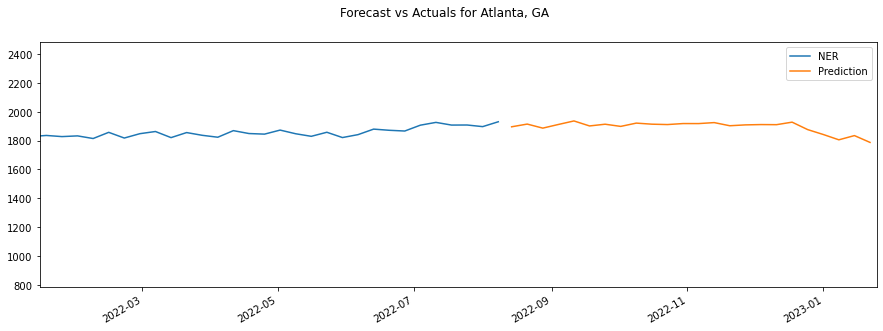

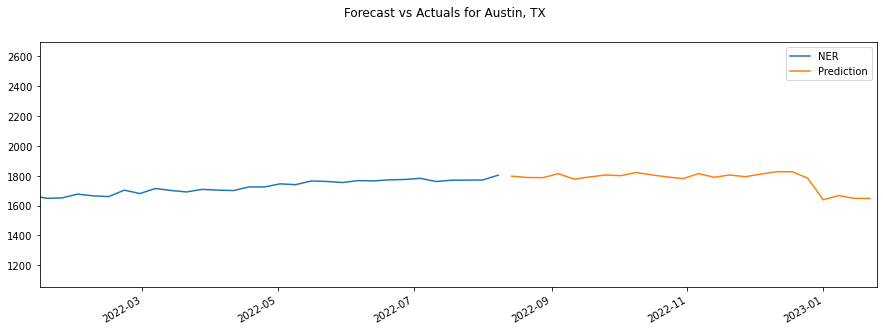

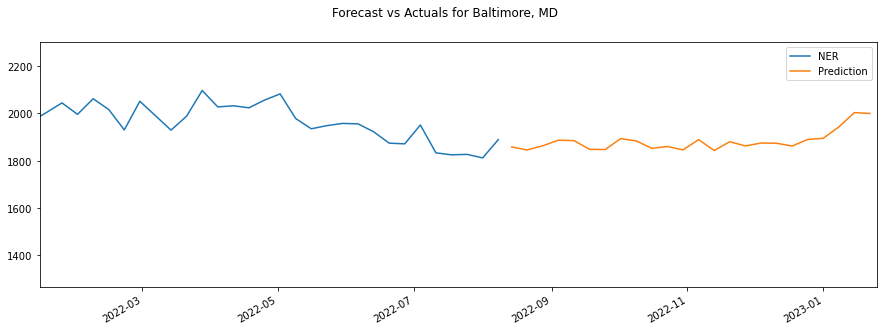

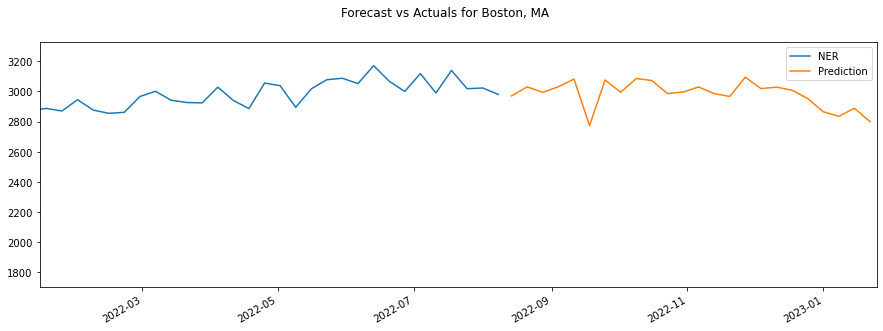

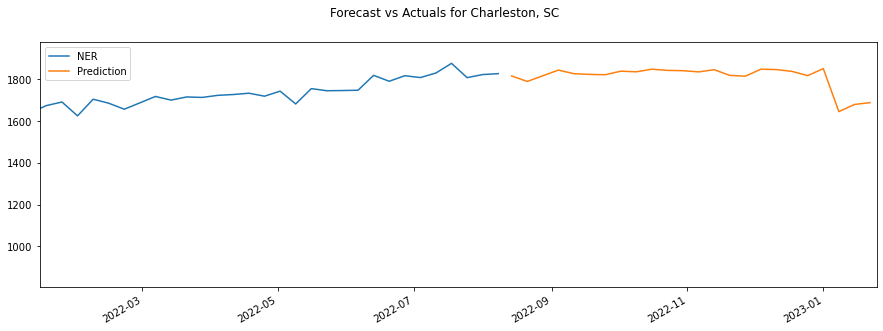

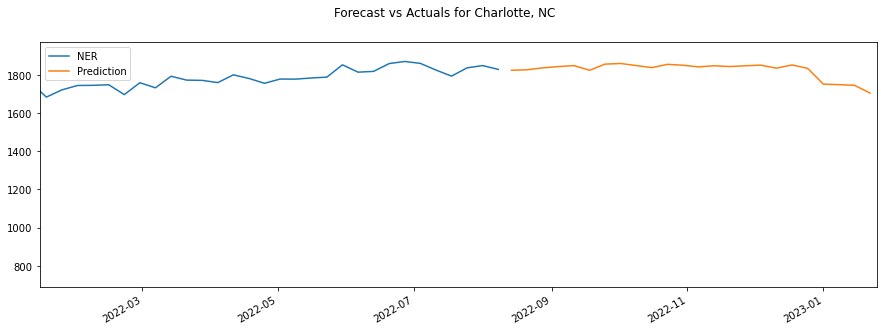

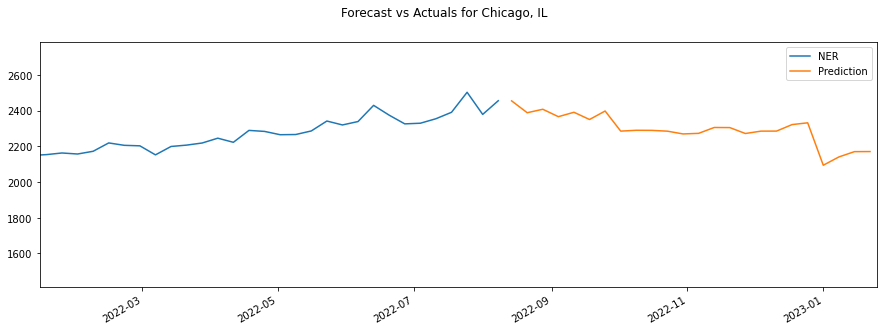

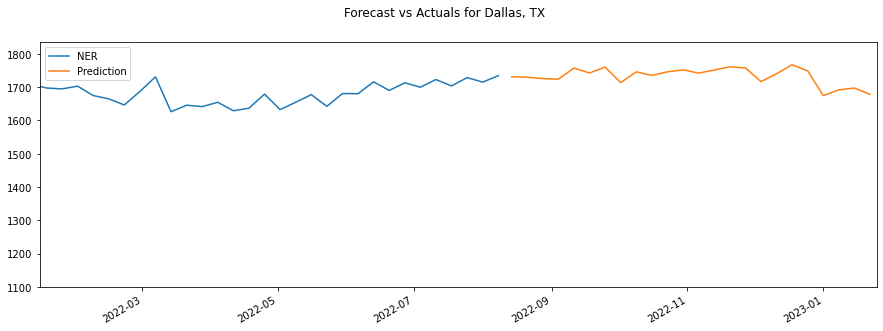

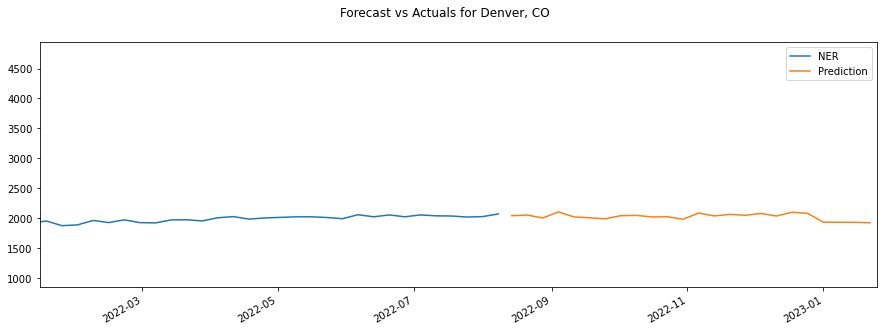

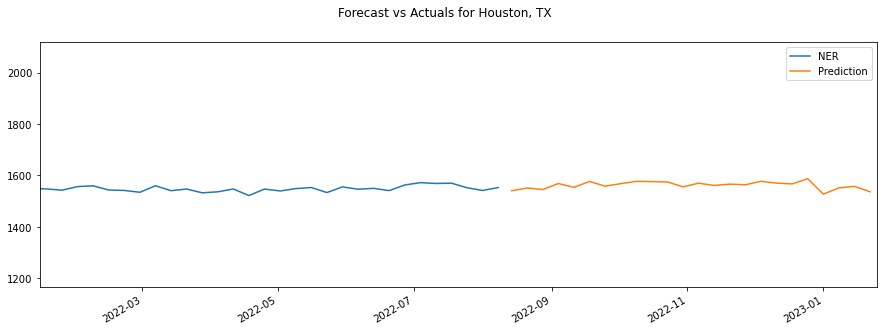

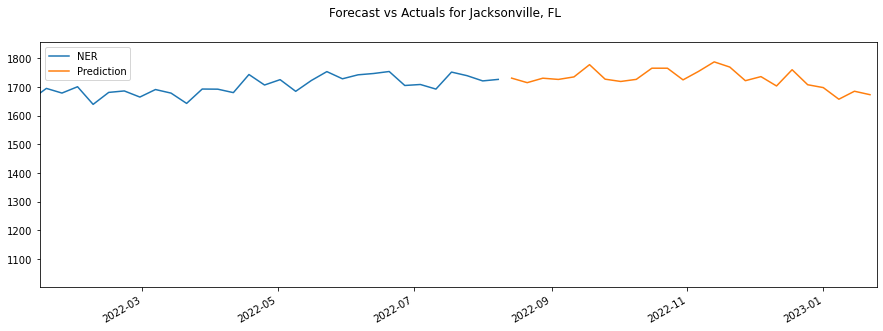

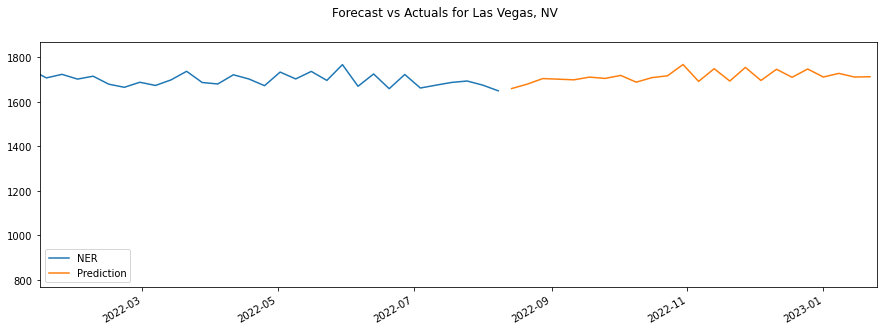

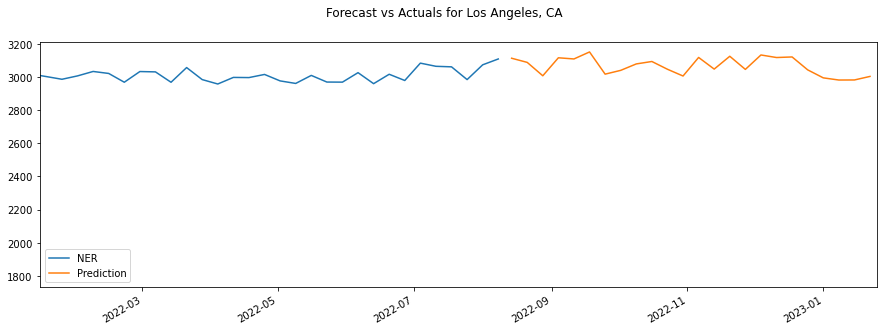

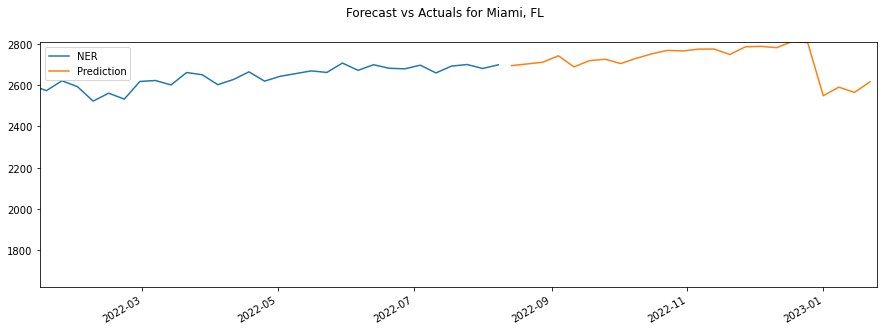

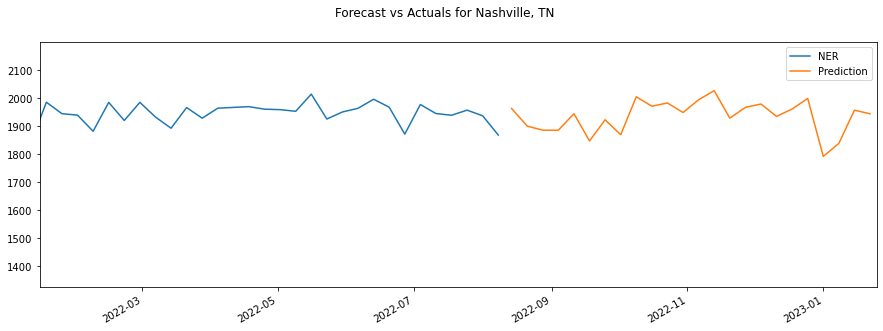

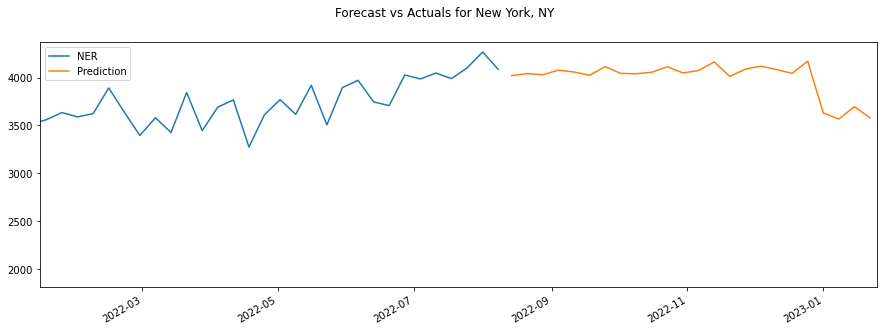

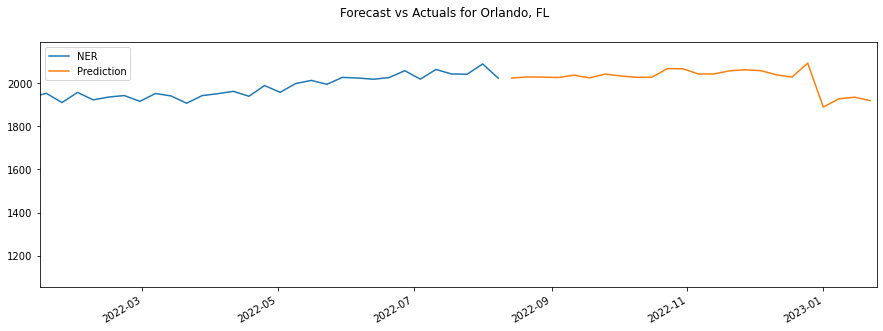

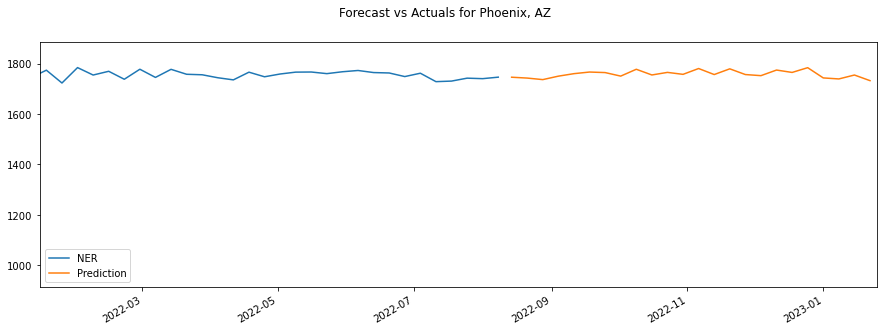

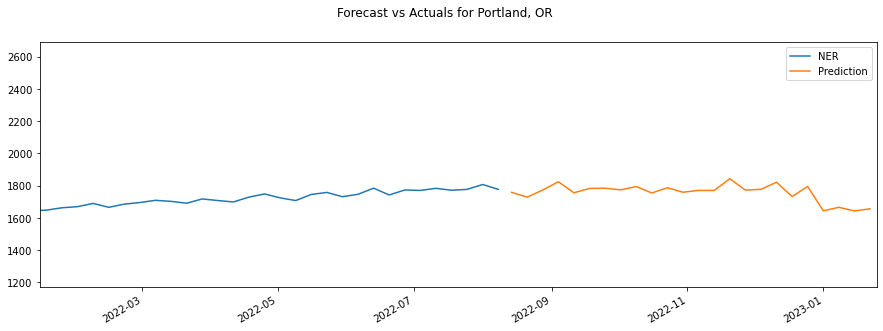

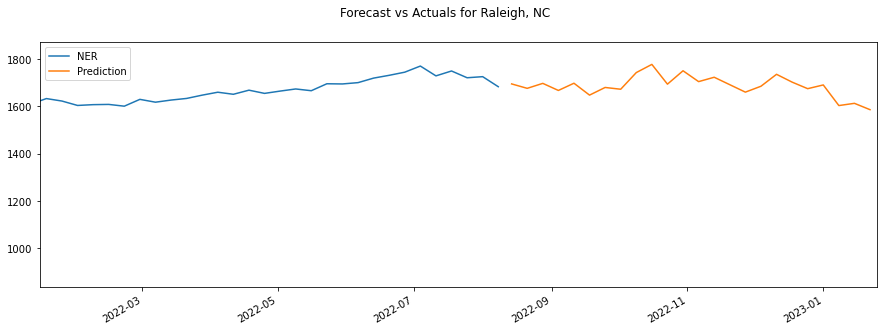

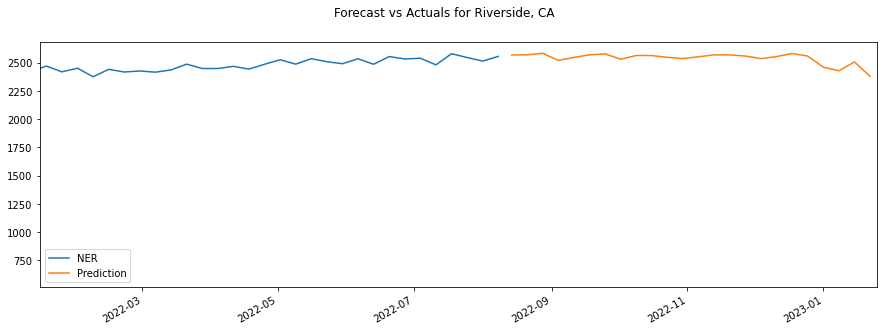

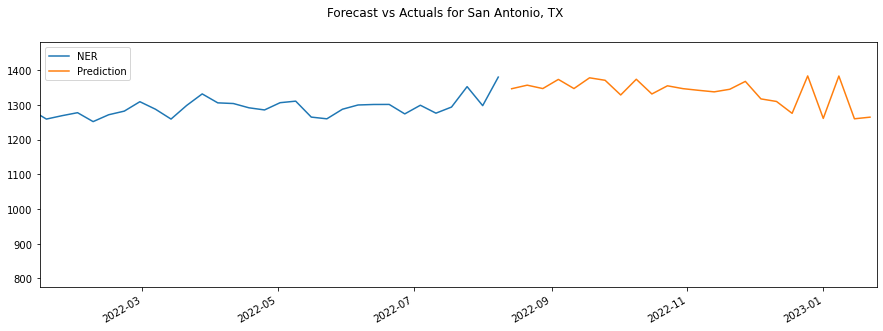

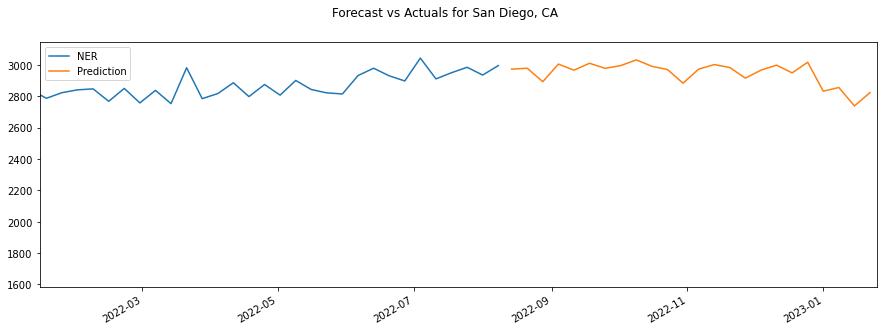

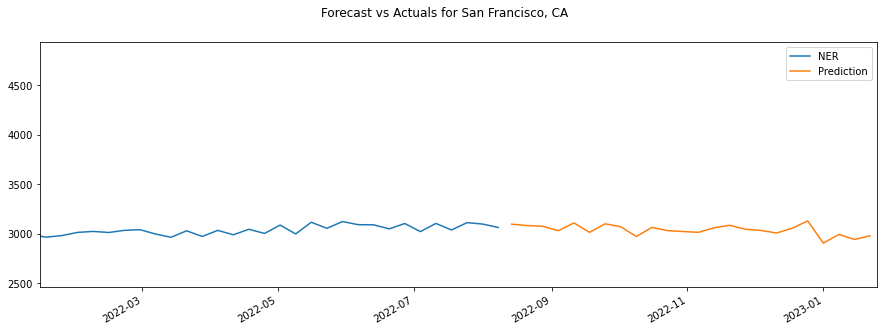

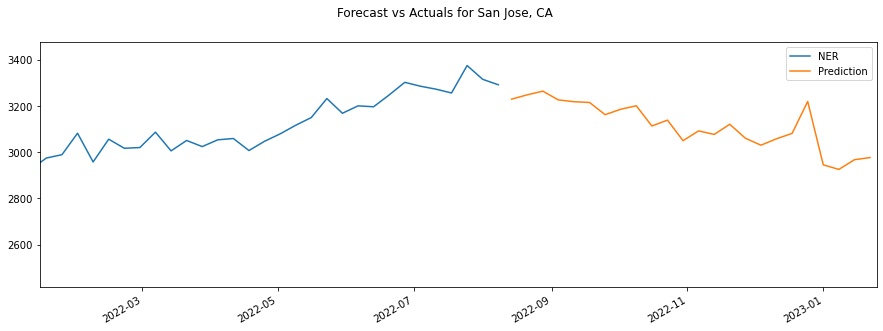

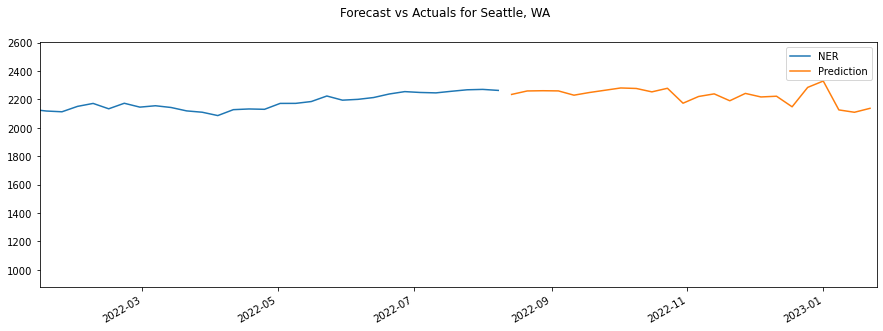

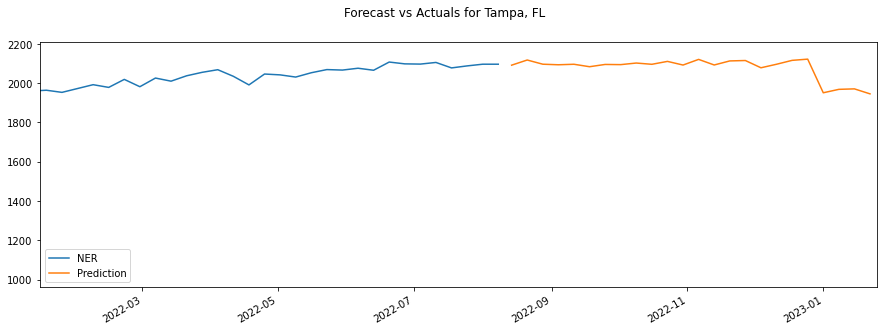

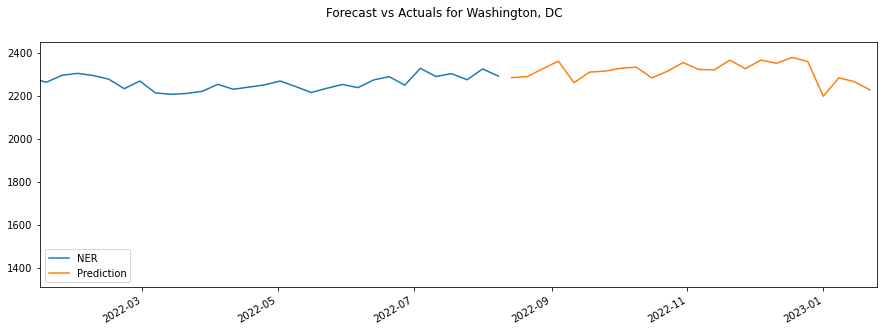

In [58]:
for unique_val, subset in subsets.items():
    if unique_val in msa_data_lst: 
        subset['date'] = subset.index
        df_train = subset
        df_train = datetime_index(df_train, 'date')
        X_train, y_train = create_features(df_train, label='NER')


        prediction_period = pd.DataFrame(pd.date_range('2022-08-08', periods=24, freq='W'))
        prediction_period = prediction_period.rename(columns = {0:'date'})
        df_test = datetime_index(prediction_period, 'date')


        X_test = create_features(df_test)


        reg = xgb.XGBRegressor(n_estimators=200)

        reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train)],
            early_stopping_rounds=50,
           verbose=False)     

        df_test['Prediction'] = reg.predict(X_test)
        df_all = pd.concat([df_test, df_train], sort=False)


        f, ax = plt.subplots(1)
        f.set_figheight(5)
        f.set_figwidth(15)
        _ = df_all[['NER','Prediction']].plot(ax=ax, style=['-','-'])


        ax.set_xbound(lower='01-14-2022', upper='01-25-2023')
        ax.set_ylim(min(subset['NER'])-100,max(subset['NER'])+100)

        plot = plt.suptitle(f'Forecast vs Actuals for {unique_val}')